# Importing all the required packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error as mse
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statistics
import warnings

In [ ]:
warnings.filterwarnings('ignore')

## Reading the all the datasets

In [5]:
train_df = pd.read_csv('train.csv')
feature_df = pd.read_csv('features.csv')
store_df = pd.read_csv('stores.csv')

In [6]:
train_df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [7]:
feature_df.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [8]:
store_df.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

## Cleaning the data files

In [6]:
train_df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [9]:
feature_df.isnull().sum() # found null values for most of the columns

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [10]:
# Replacing null values with 0 for all integer type features
feature_df.fillna(0, inplace = True)

In [11]:
feature_df.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

In [12]:
store_df.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

# Merging all the datasets into one final dataframe

In [243]:
data = train_df.merge(feature_df, on=['Store', 'Date']).merge(store_df, on=['Store'])
data.head()

Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     2  2010-02-05      50605.27        False        42.31   
2      1     3  2010-02-05      13740.12        False        42.31   
3      1     4  2010-02-05      39954.04        False        42.31   
4      1     5  2010-02-05      32229.38        False        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.572        0.0        0.0        0.0        0.0        0.0   
2       2.572        0.0        0.0        0.0        0.0        0.0   
3       2.572        0.0        0.0        0.0        0.0        0.0   
4       2.572        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment  IsHoliday_y Type    Size  
0  211.096358         8.106        False    A  151315  
1  211.096358         8.106        False    A  151315  
2  211.096358         8.106        False    A  151315  
3  211.096358         8.106        False    A  151315  
4  211.096358         8.106        False    A  151315

In [18]:
#Checking for inaccurate data points and found 0.3% of weeklysales as less than or equal to zero
len(data[data['Weekly_Sales'] <= 0])/len(data) * 100

0.0

In [19]:
data = data[data['Weekly_Sales'] > 0] # Removing the inaccurate data points

In [225]:
data.head()

Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     2  2010-02-05      50605.27        False        42.31   
2      1     3  2010-02-05      13740.12        False        42.31   
3      1     4  2010-02-05      39954.04        False        42.31   
4      1     5  2010-02-05      32229.38        False        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.572        0.0        0.0        0.0        0.0        0.0   
2       2.572        0.0        0.0        0.0        0.0        0.0   
3       2.572        0.0        0.0        0.0        0.0        0.0   
4       2.572        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment  IsHoliday_y Type    Size  
0  211.096358         8.106        False    A  151315  
1  211.096358         8.106        False    A  151315  
2  211.096358         8.106        False    A  151315  
3  211.096358         8.106        False    A  151315  
4  211.096358         8.106        False    A  151315

In [23]:
#converting the string type to date type for 'Date' column
data['Date'] = pd.to_datetime(data['Date'])

In [232]:
data['Store'].nunique()

45

In [234]:
data['Dept'].nunique()

81

In [245]:
#writing the final cleaned data into a file
data = data.drop('IsHoliday_x', axis = 1)
data = data.rename(columns = {'IsHoliday_y': 'IsHoliday'})
#data.to_csv("C:\\Users\\DELL\\Desktop\\Rutgers\\Sem1\\Regression\\Project\\clean_data.csv")

In [246]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   Temperature   421570 non-null  float64
 5   Fuel_Price    421570 non-null  float64
 6   MarkDown1     421570 non-null  float64
 7   MarkDown2     421570 non-null  float64
 8   MarkDown3     421570 non-null  float64
 9   MarkDown4     421570 non-null  float64
 10  MarkDown5     421570 non-null  float64
 11  CPI           421570 non-null  float64
 12  Unemployment  421570 non-null  float64
 13  IsHoliday     421570 non-null  bool   
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


## Univariate Analysis

In [26]:
# Only Store, Date and Weekly_Sales columns are required for univariate time series analysis
columns = ['Store', 'Weekly_Sales', 'Date']
univ_df = data.loc[:, data.columns.isin(columns)]
univ_df.head()

Store       Date  Weekly_Sales
0      1 2010-02-05      24924.50
1      1 2010-02-05      50605.27
2      1 2010-02-05      13740.12
3      1 2010-02-05      39954.04
4      1 2010-02-05      32229.38

In [28]:
# Removing the department wise sales and aggregating the total sales for each store per week
univ_df = univ_df.groupby(['Store', 'Date']).sum('Weekly_Sales').reset_index().set_index('Date')
univ_df.head()

Store  Weekly_Sales
Date                           
2010-02-05      1    1643690.90
2010-02-12      1    1641957.44
2010-02-19      1    1612831.17
2010-02-26      1    1409727.59
2010-03-05      1    1554806.68

In [31]:
# Ordering the stores based on their total sales
sorted_df = univ_df.groupby('Store').sum("Weekly_Sales").sort_values("Weekly_Sales").reset_index()
sorted_df.tail(5)

Store  Weekly_Sales
40      2  2.753872e+08
41     13  2.865180e+08
42     14  2.890019e+08
43      4  2.995453e+08
44     20  3.014014e+08

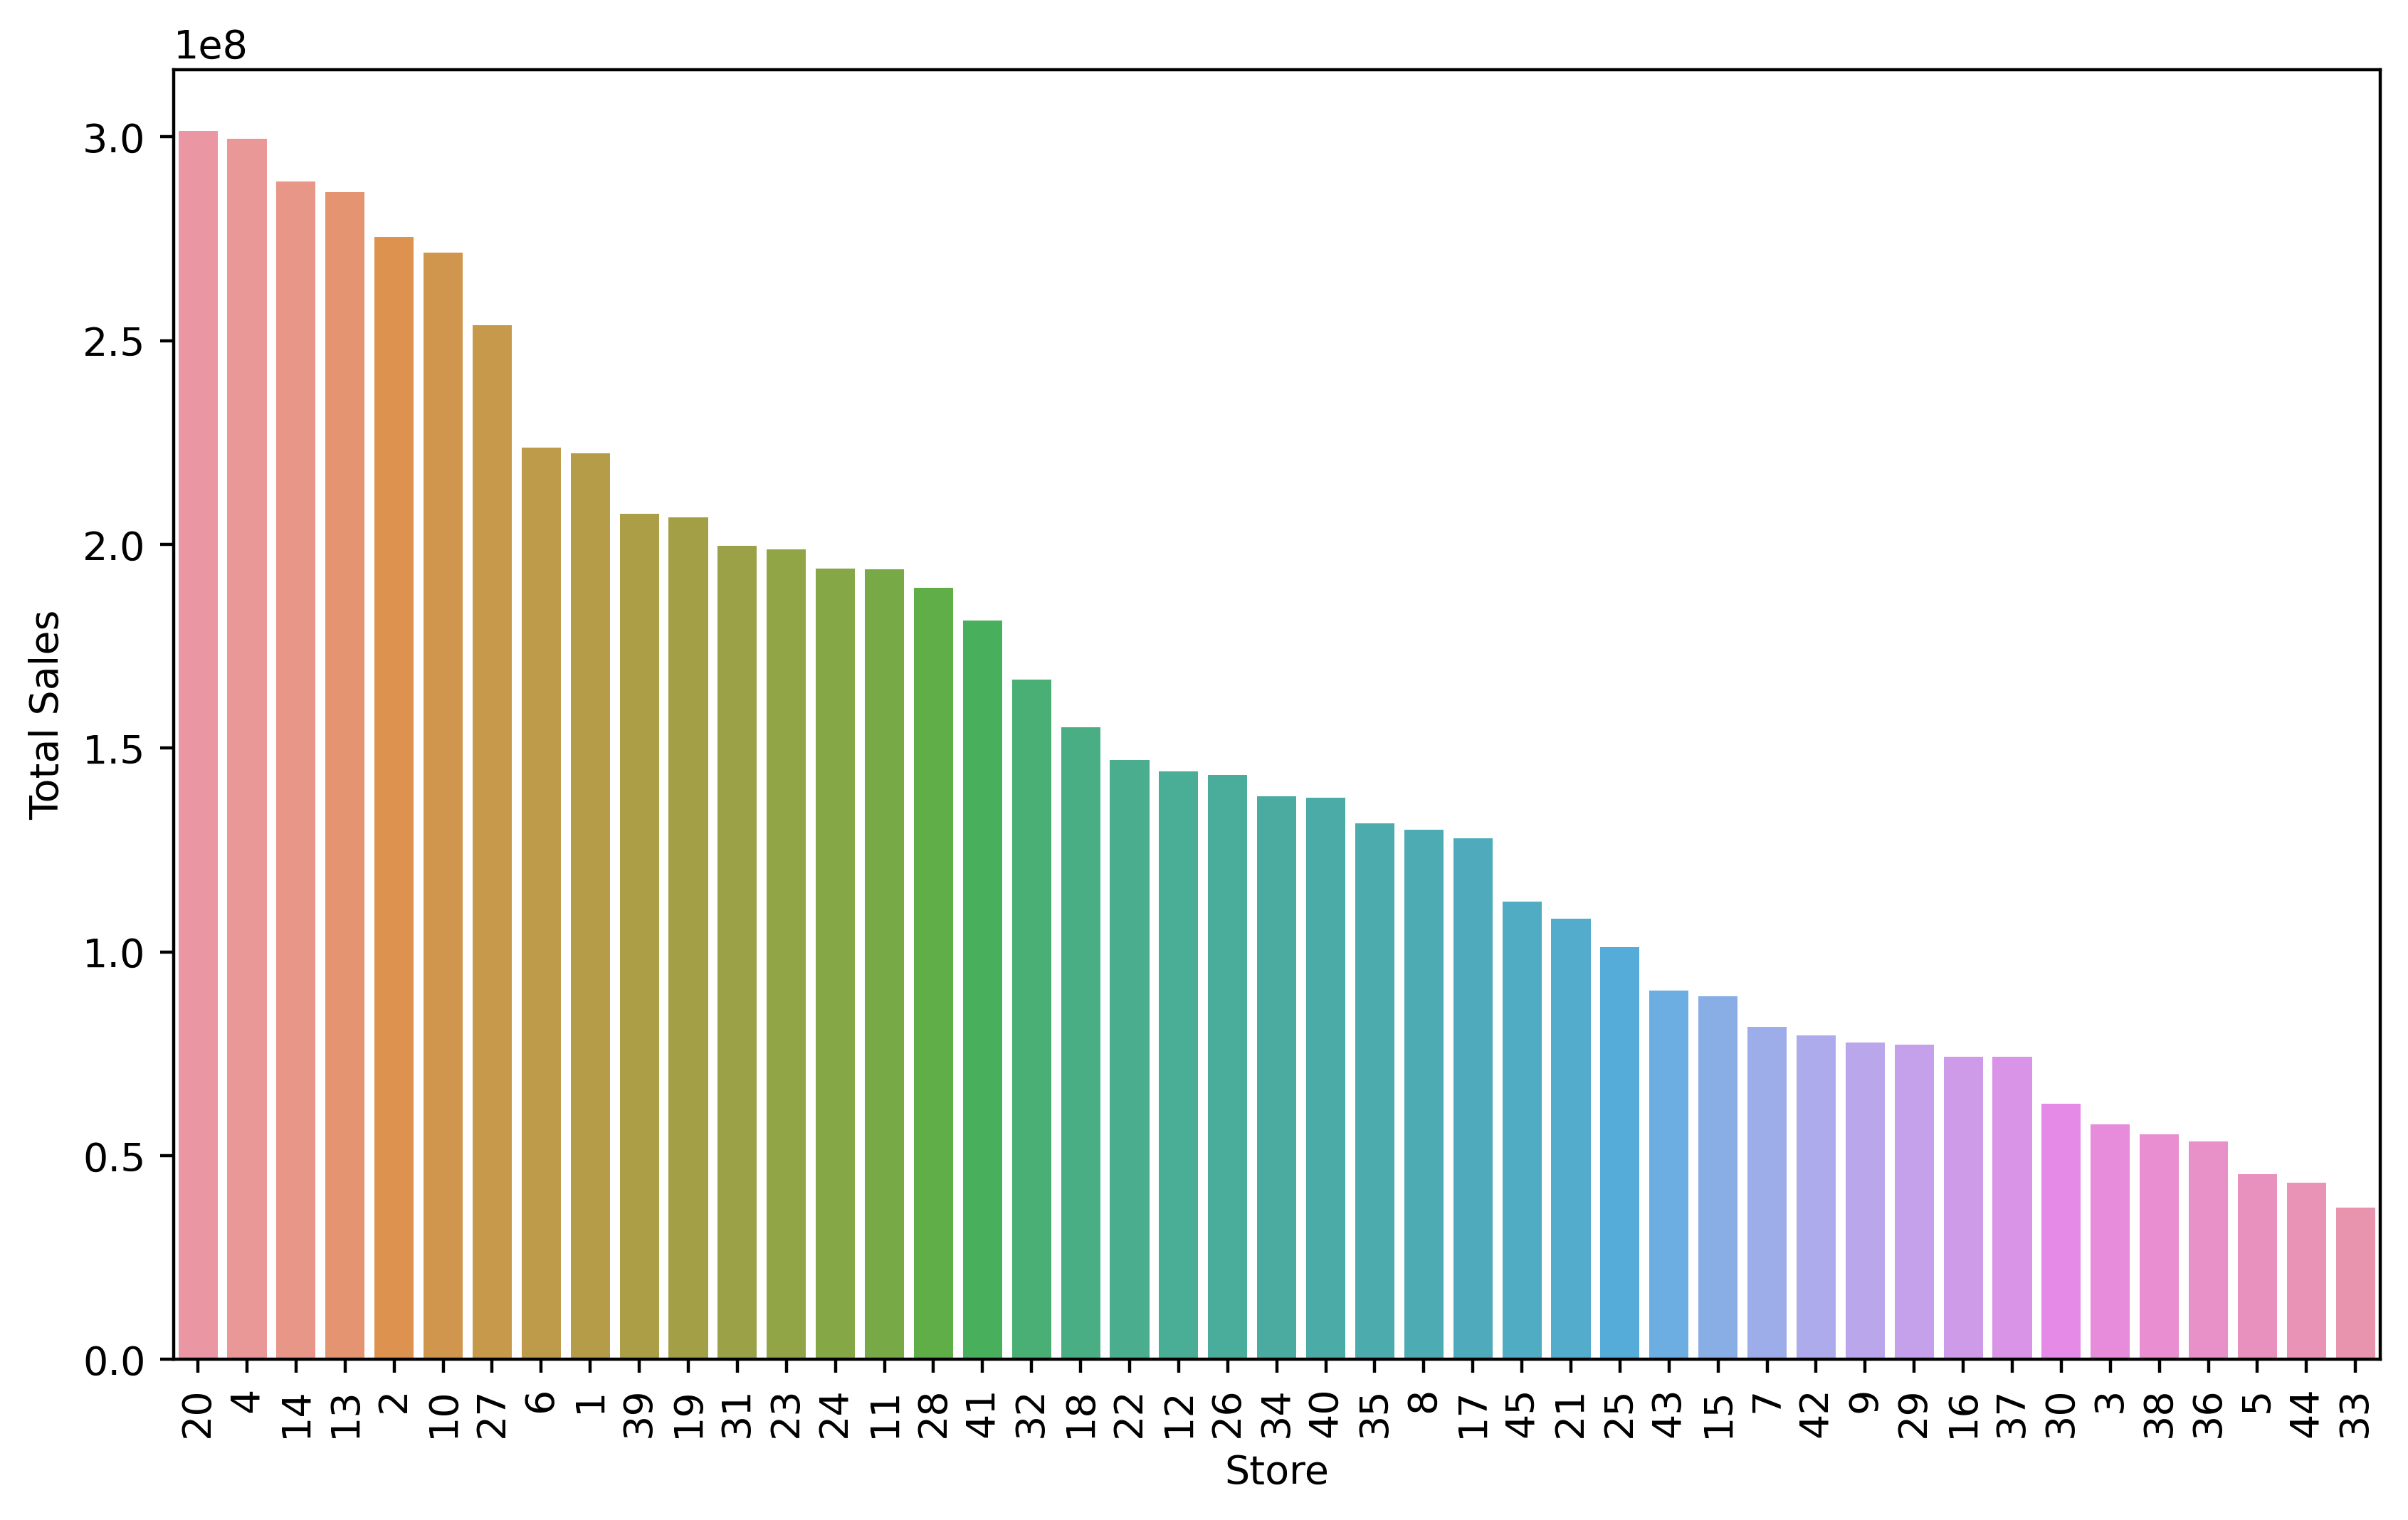

In [38]:
plt.figure(figsize = (10,6), dpi = 400)
sns.barplot(x = 'Store', y = 'Weekly_Sales', data = sorted_df, order = sorted_df.sort_values('Weekly_Sales',ascending = False).Store)
plt.ylabel("Total Sales")
plt.xticks(rotation = 90);

## Univariate Analysis for store 20

In [249]:
#Taking only the store 20 sales data
store20 = univ_df[univ_df['Store'] == 20]
store20.drop('Store', axis = 1, inplace = True)
store20.head()

Weekly_Sales
Date                    
2010-02-05    2401395.47
2010-02-12    2109107.90
2010-02-19    2161549.76
2010-02-26    1898193.95
2010-03-05    2119213.72

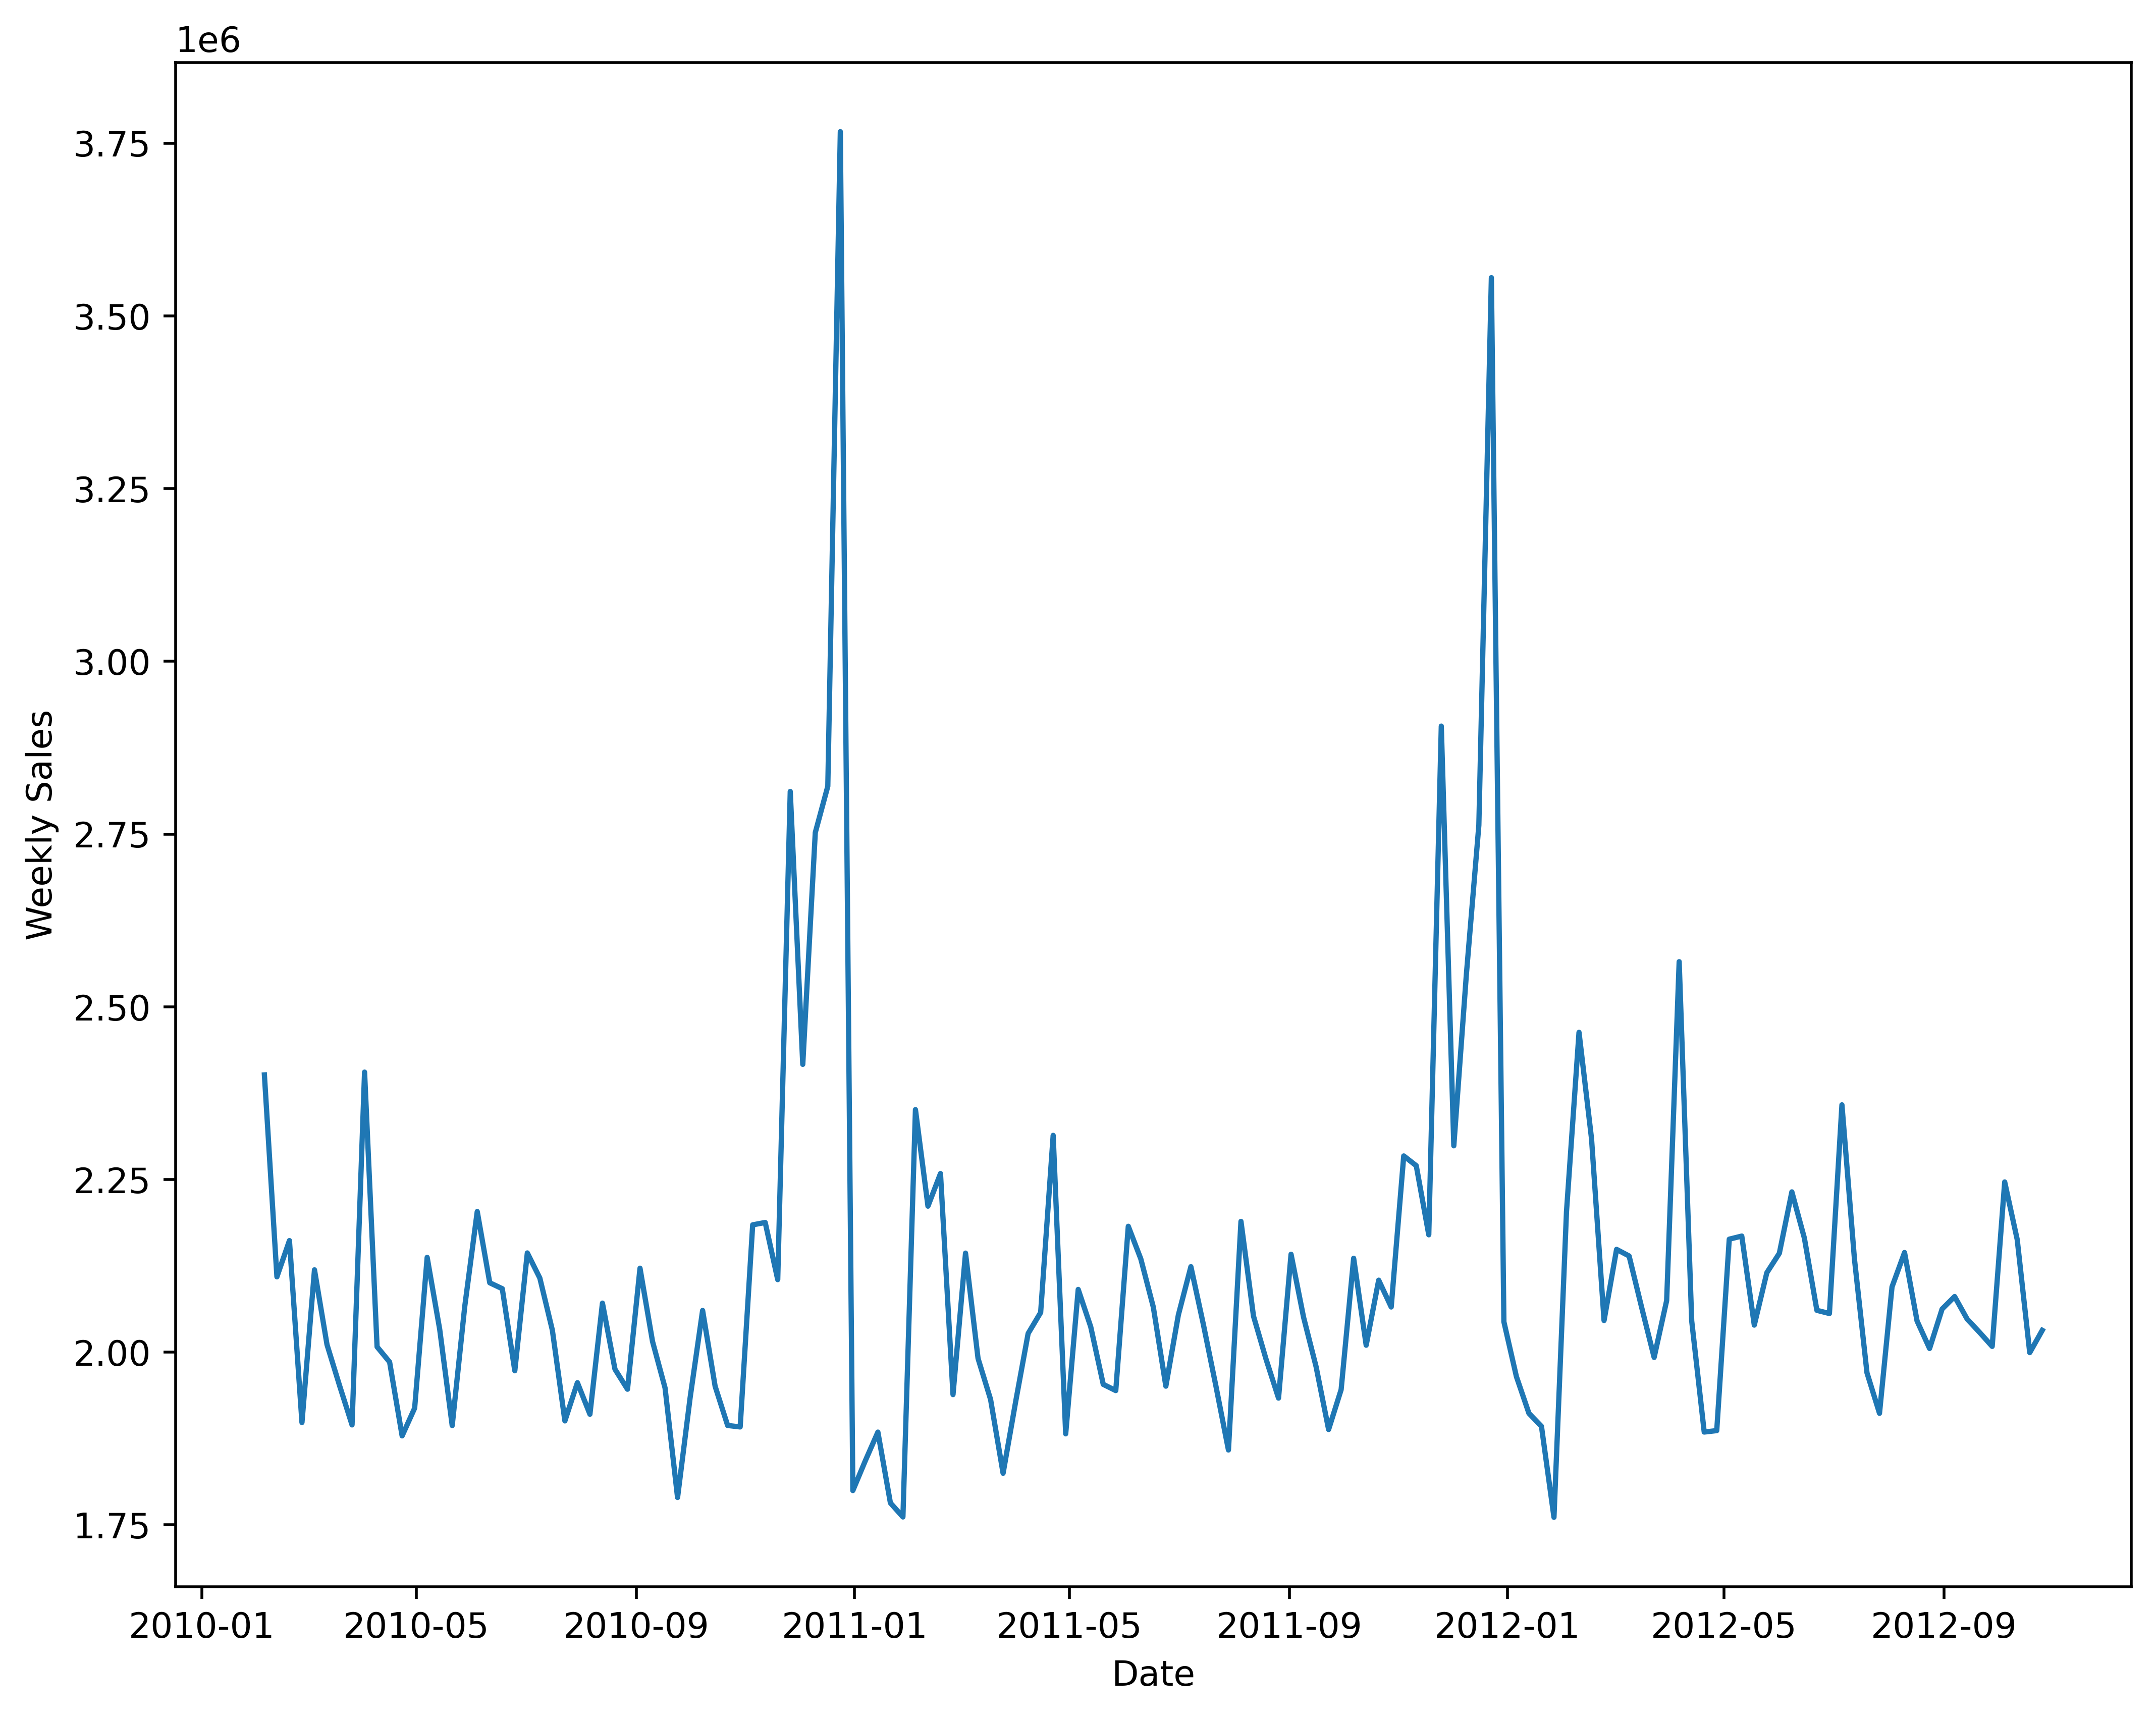

In [250]:
plt.figure(figsize = (10,8), dpi = 500)
plt.plot(store20)
plt.ylabel("Weekly Sales")
plt.xlabel("Date");

# Splitting the data into 75% train and 25% test data

In [251]:
train, test = train_test_split(store20, test_size = 0.25, shuffle = False)

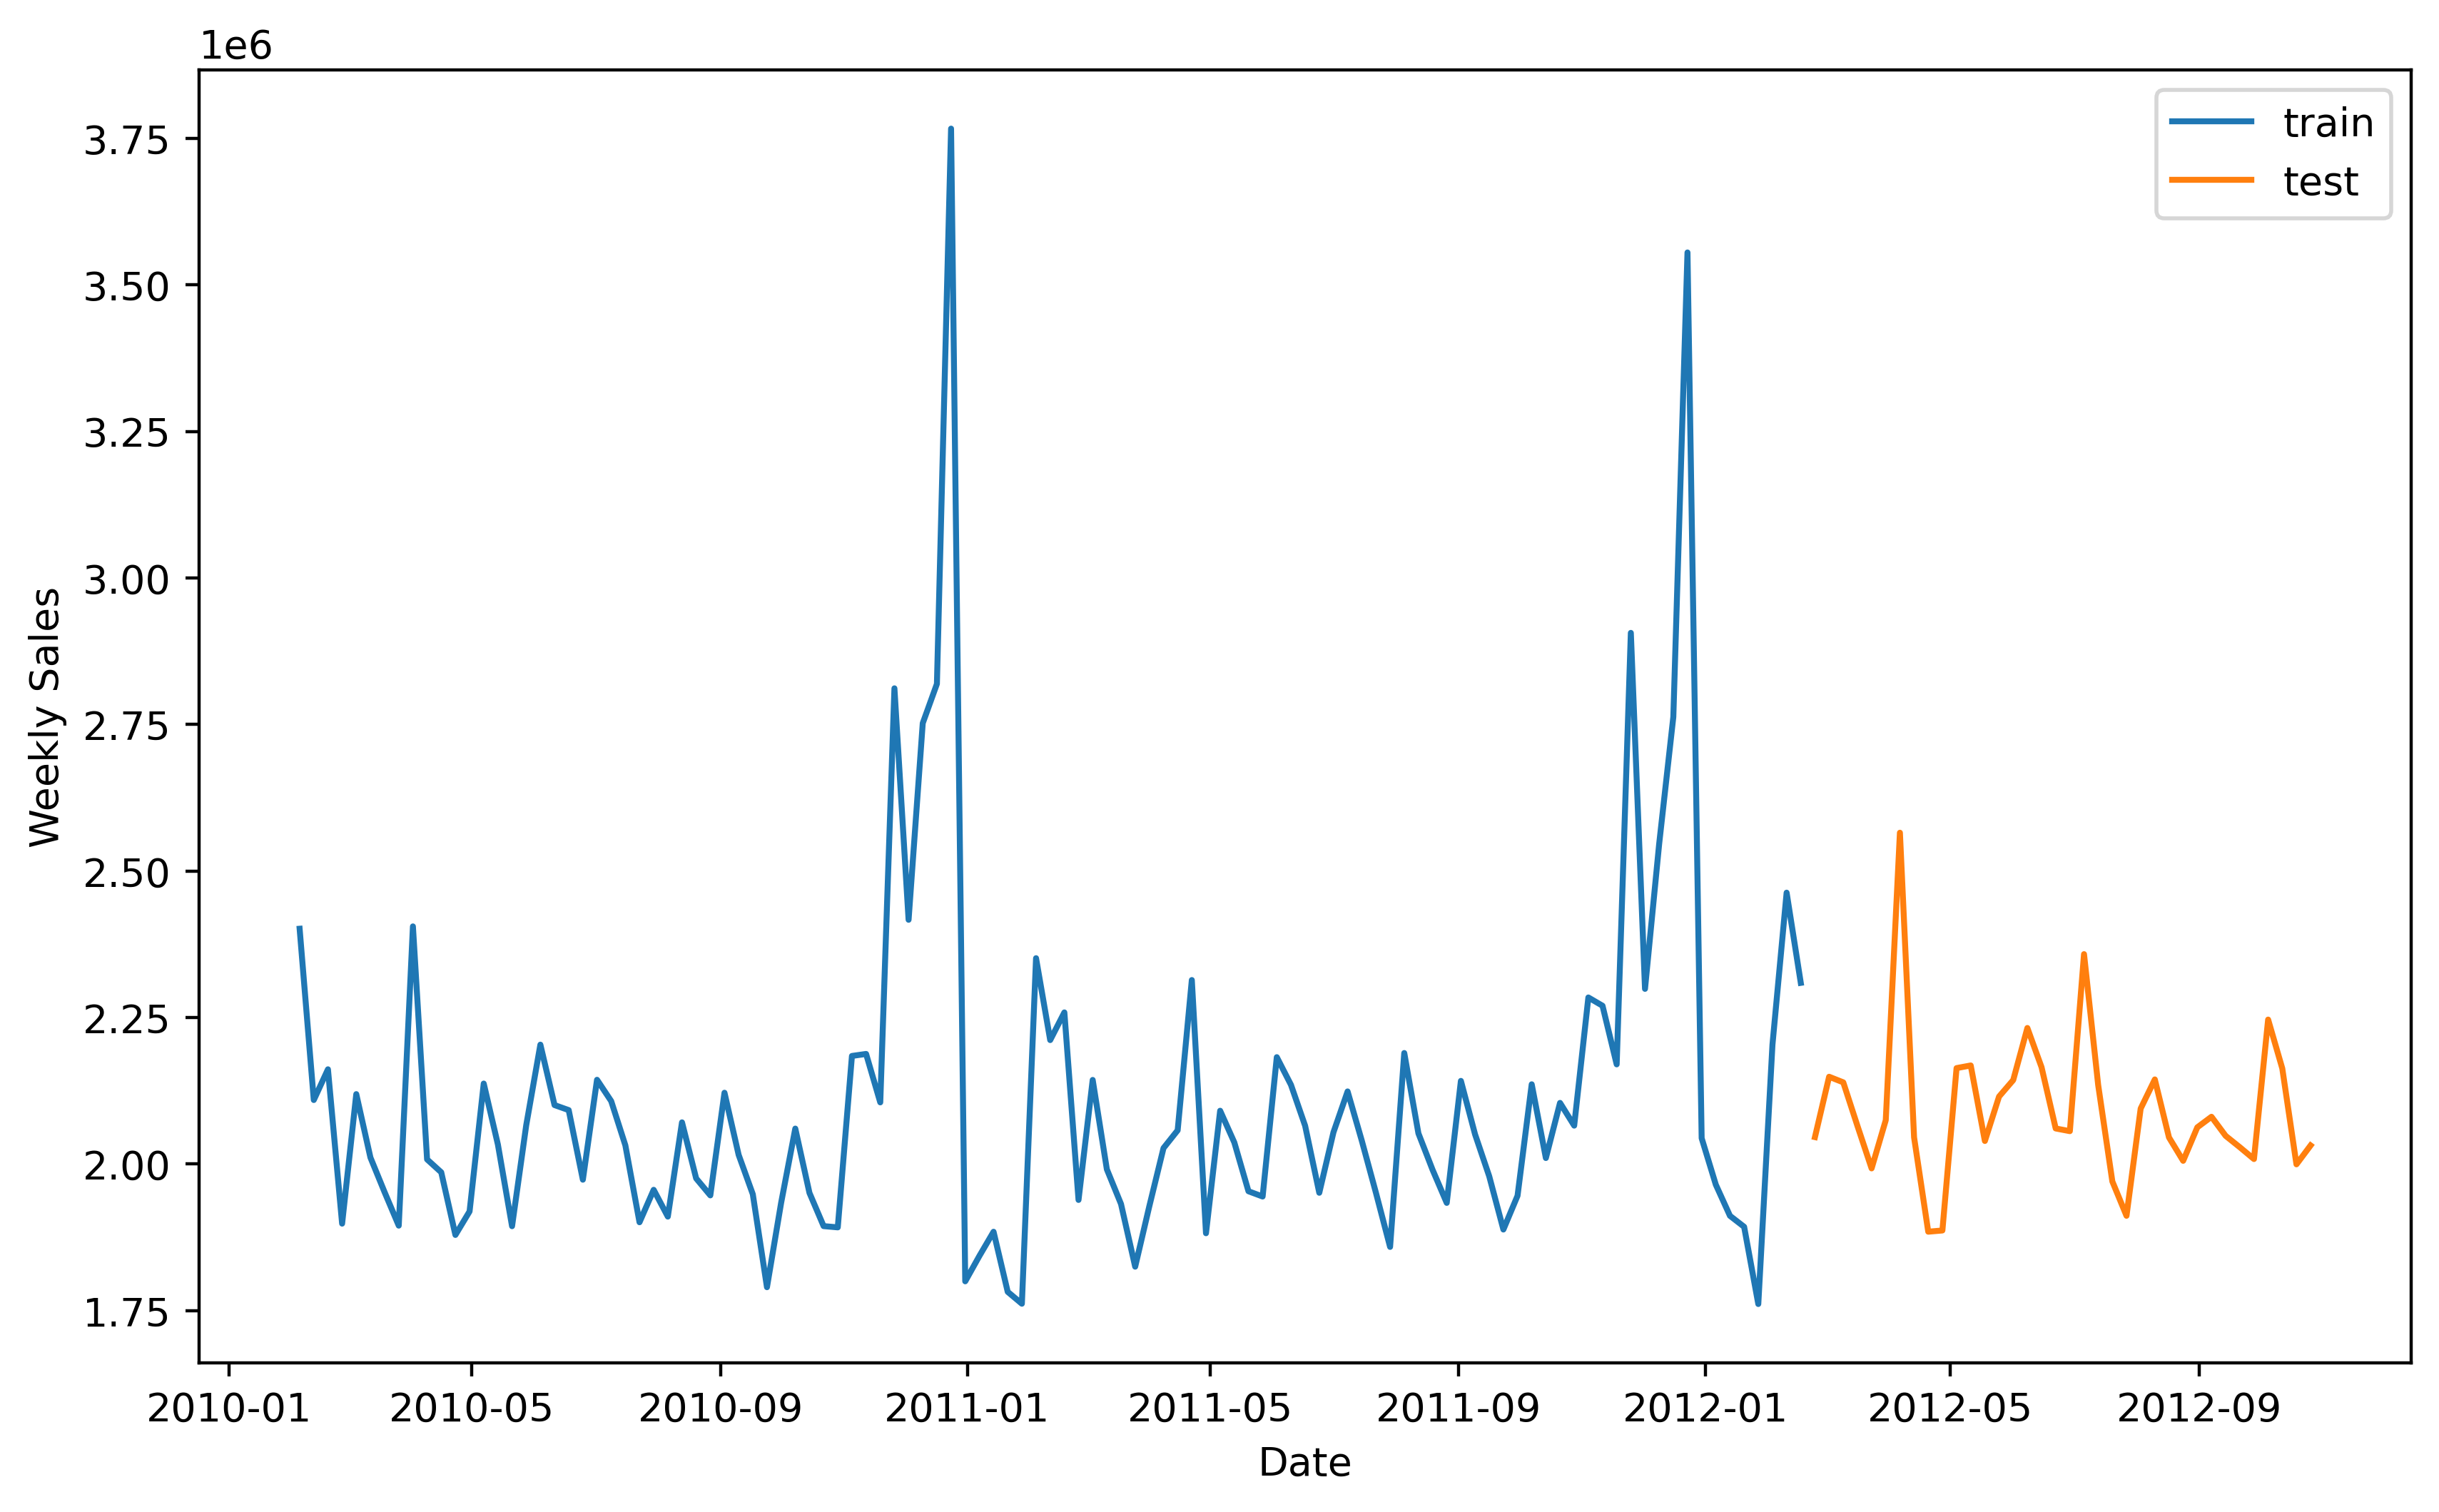

In [252]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.legend()
plt.ylabel("Weekly Sales")
plt.xlabel("Date");

# Checking for autocorrelation for 52 lags

(-0.5, 0.5)

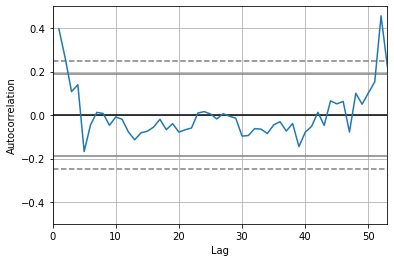

In [26]:
autocorrelation_plot(train["Weekly_Sales"])
plt.xlim(0,53)
plt.ylim(-0.5, 0.5)

<Figure size 10000x5000 with 0 Axes>

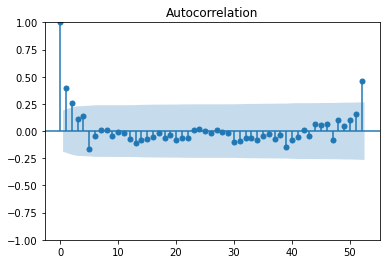

In [52]:
#Autocorrelation Function (ACF)
plt.figure(figsize = (20,10), dpi = 500)
plot_acf(train['Weekly_Sales'], lags = 52);

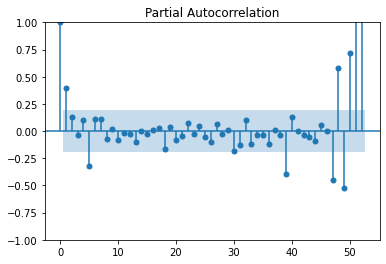

In [54]:
# Partial autocorrelation function (PACF) 
plot_pacf(train['Weekly_Sales'], lags = 52);

In [254]:
print("1 week", train['Weekly_Sales'].autocorr(lag = 1))
print("2 week", train['Weekly_Sales'].autocorr(lag = 2))
print("3 week", train['Weekly_Sales'].autocorr(lag = 3))
print("1 month", train['Weekly_Sales'].autocorr(lag = 4))
print("2 months", train['Weekly_Sales'].autocorr(lag = 8))
print("3 months", train['Weekly_Sales'].autocorr(lag = 12))
print("1 year", train['Weekly_Sales'].autocorr(lag = 50))

1 week 0.3986660200197726
2 week 0.26505842511502686
3 week 0.10905647395931288
1 month 0.142451352647084
2 months 0.007661319628260466
3 months -0.09323089263908618
1 year 0.19810578766597026


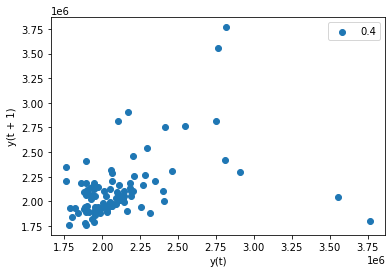

In [55]:
# Plotting the auto correlation for lag = 1
pd.plotting.lag_plot(train['Weekly_Sales'], lag = 1)
plt.legend([np.round(train['Weekly_Sales'].autocorr(lag = 1), 2).astype('str')])

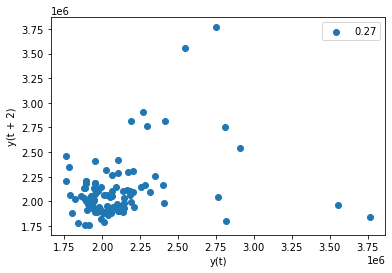

In [56]:
# Plotting the auto correlation for lag = 2
pd.plotting.lag_plot(train['Weekly_Sales'], lag = 2)
plt.legend([np.round(train['Weekly_Sales'].autocorr(lag = 2), 2).astype('str')])

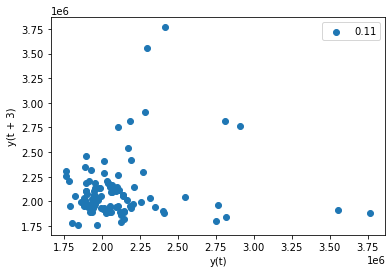

In [57]:
# Plotting the auto correlation for lag = 3
pd.plotting.lag_plot(train['Weekly_Sales'], lag = 3)
plt.legend([np.round(train['Weekly_Sales'].autocorr(lag = 3), 2).astype('str')])

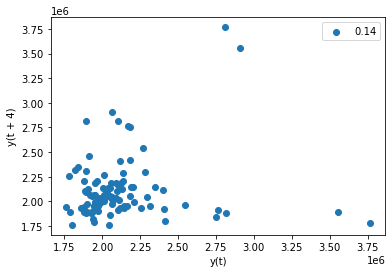

In [58]:
# Plotting the auto correlation for lag = 4
pd.plotting.lag_plot(train['Weekly_Sales'], lag = 4)
plt.legend([np.round(train['Weekly_Sales'].autocorr(lag = 4), 2).astype('str')])

## From the above graphs, we can say that lag 1 has the best correlation

# Checking for stationarity using Augmented Dickey Fuller test

In [255]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [256]:
test_stationarity(train)

Results of Dickey-Fuller Test:
Test Statistic                  -4.719934
p-value                          0.000077
#Lags Used                       4.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


## From the above test results, as the p value is less than 0.05, we can say that with 95% confidence interval our data is stationary

# Modeling

## Auto Regression 

In [257]:
# A common function to get the test results
def results(model, test, store):
    start_test = test.index[0]
    end_test = test.index[-1]
    yhat_test = model.predict(start = start_test, end = end_test)
    print("Mean absolute percentage error -", np.round((abs(yhat_test - test['Weekly_Sales'])/ test['Weekly_Sales'] * 100).mean(), 1),"%")
    return yhat_test

In [258]:
# Chose the lag =1 from the above PACF plot
autoreg = AutoReg(train, lags = 1).fit()
yhat_autoreg = results(autoreg, test, store20)

Mean absolute percentage error - 4.4 %


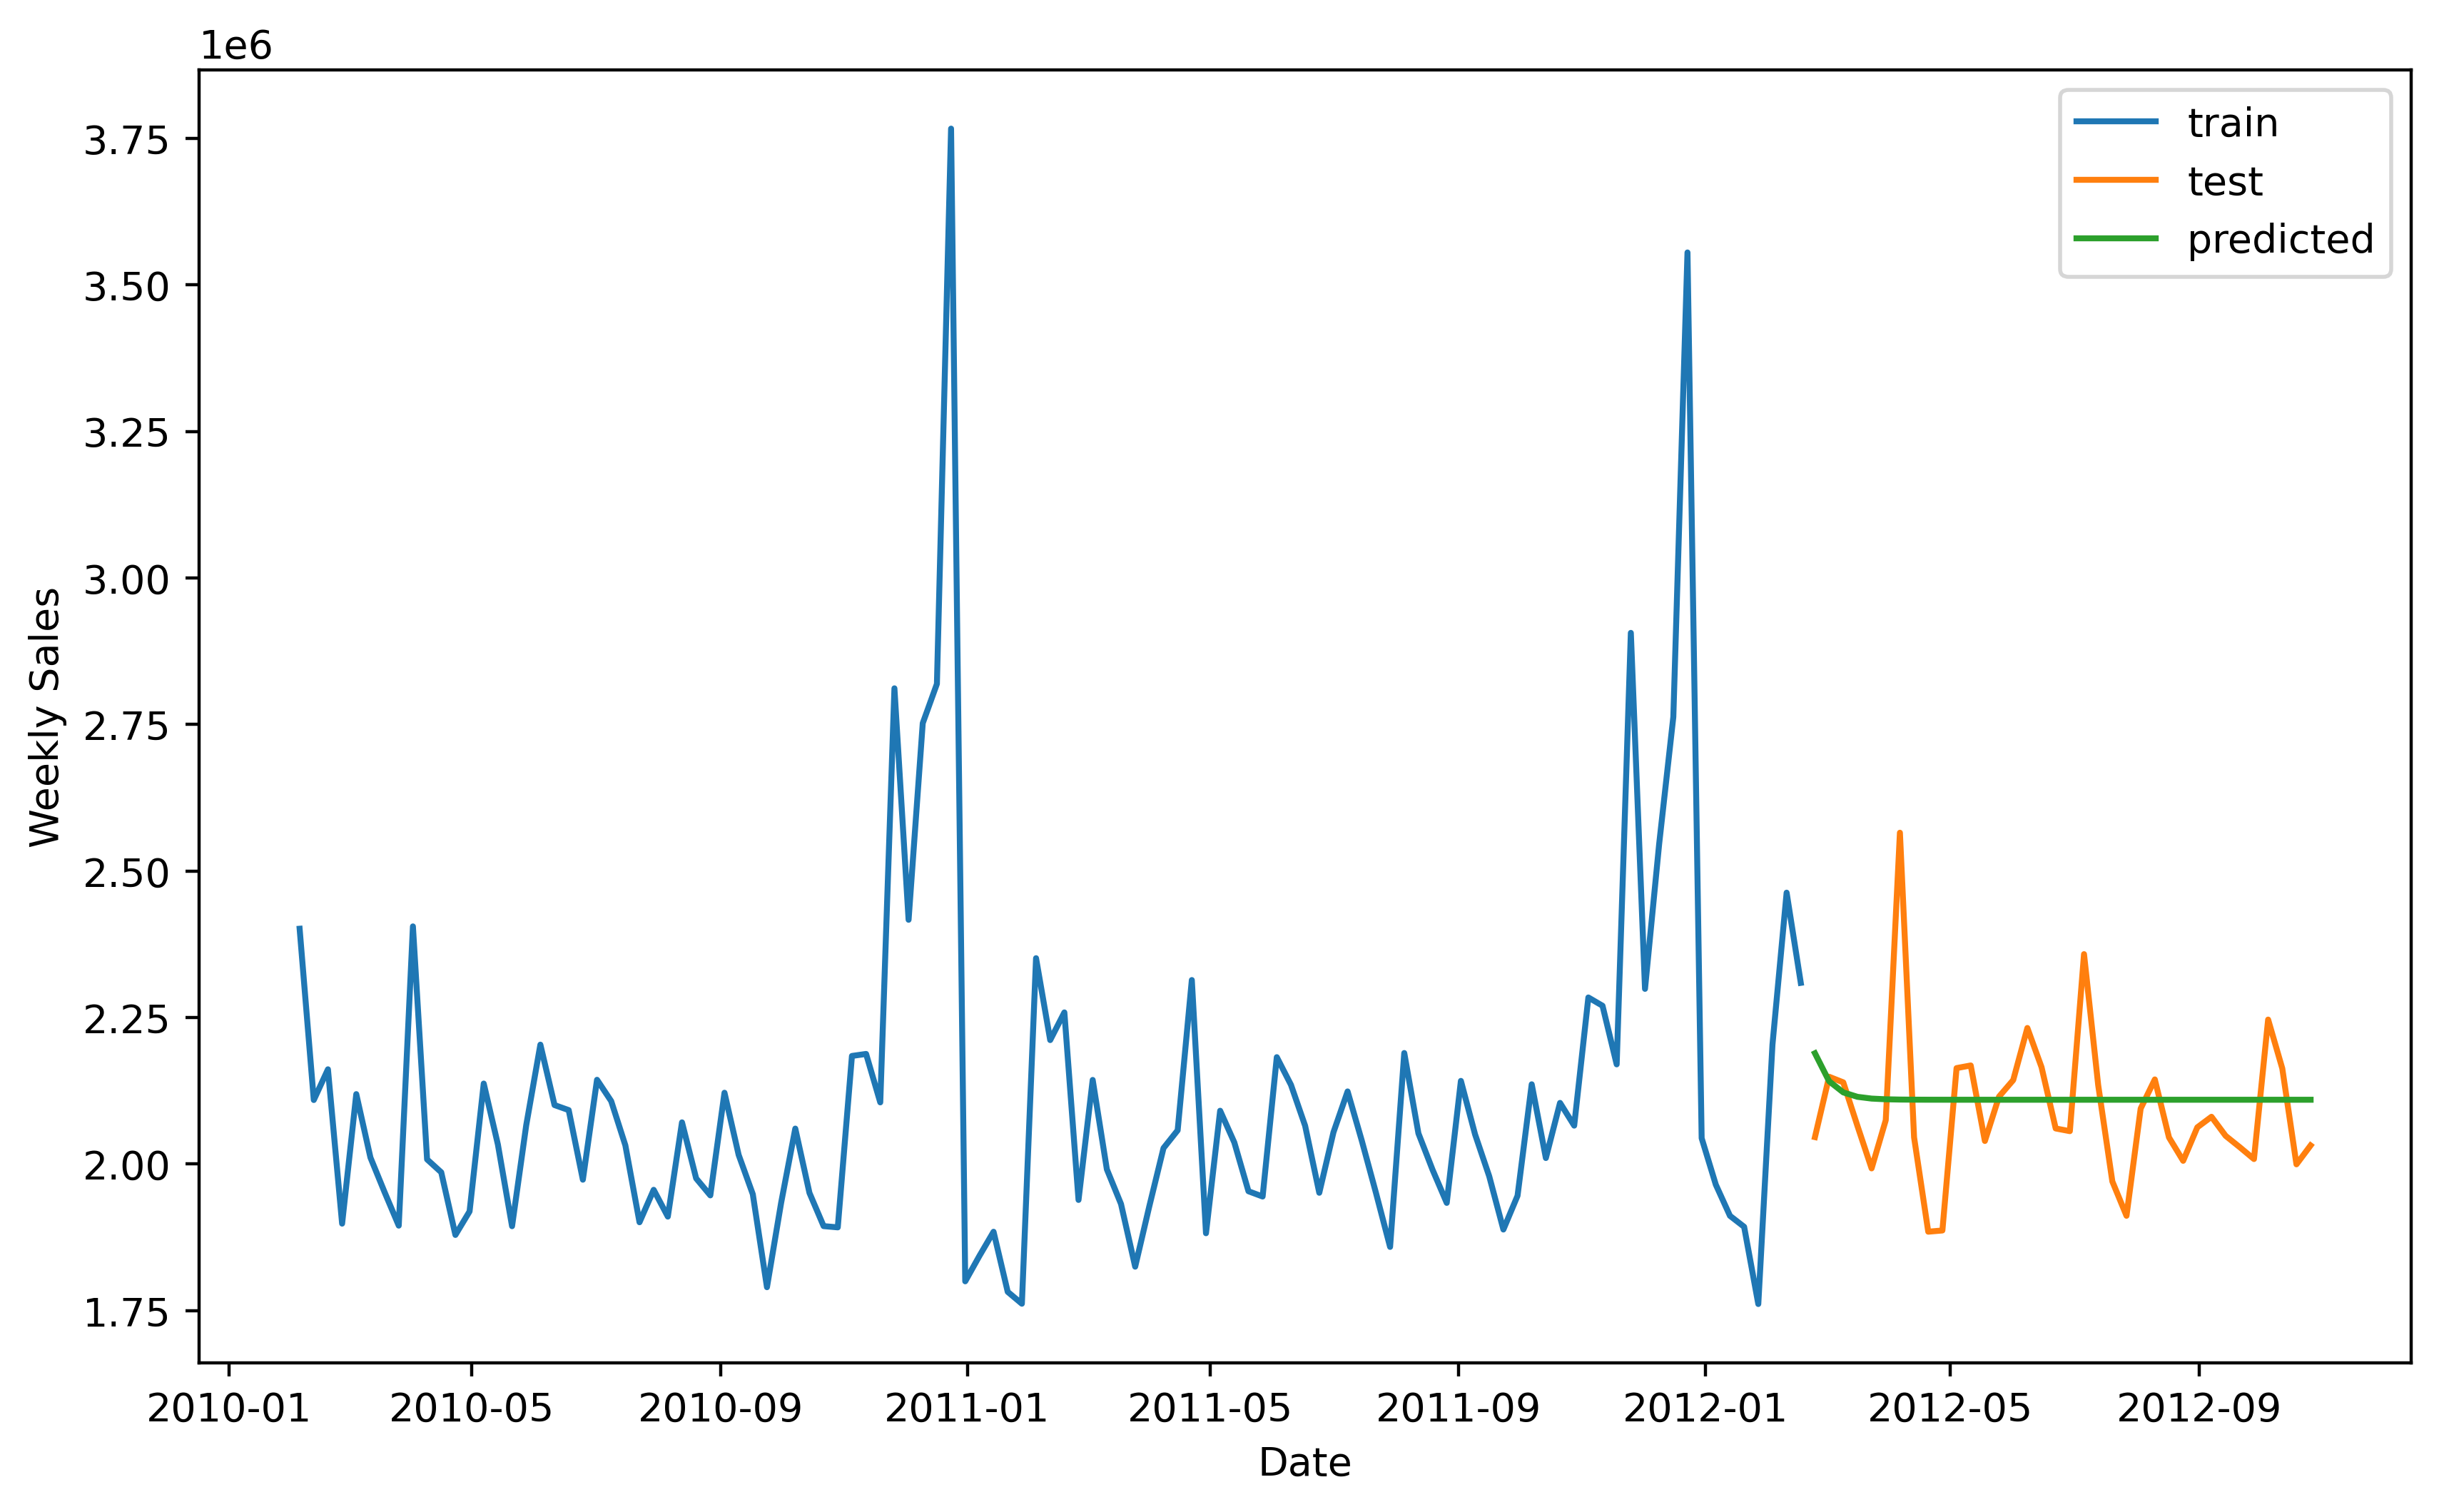

In [77]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = "train")
plt.plot(test, label = "test");
plt.plot(yhat_autoreg, label = "predicted")
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.legend();

## Auto Arima

In [78]:
# Running auto arima to find the best hyper parameterts for arima model
model_auto_arima = auto_arima(train, trace = True, start_p = 0, start_q = 0, start_P = 0, start_Q = 0,
                  max_p = 20, max_q = 20, max_P = 20, max_Q = 20, seasonal = True, maxiter = 200,
                  information_criterion = 'aic', stepwise = False, suppress_warnings = True, D = 1, max_D = 10,
                  error_action = 'ignore',approximation = False)
model_auto_arima.fit(train)
start_test = test.index[0]
end_test = test.index[-1]
yhat_test = model_auto_arima.predict(n_periods = len(test))

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=3013.055, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=3002.727, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=2998.857, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=3000.757, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=2989.606, Time=0.08 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=2988.512, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=2996.701, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=2997.832, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=2999.603, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=3001.441, Time=0.08 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=2994.012, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=2996.995, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=2998.971, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=2999.599, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=2998.043, Time=0.16 sec
 ARIMA(3,0

## Autoregressive integrated moving average(ARIMA)

In [85]:
arima = ARIMA(train, order = (0, 0, 5)).fit() # lags = 0, differencing = 0, moving averages = 5
yhat_arima = results(arima, test, store20)

Mean absolute percentage error - 4.6 %


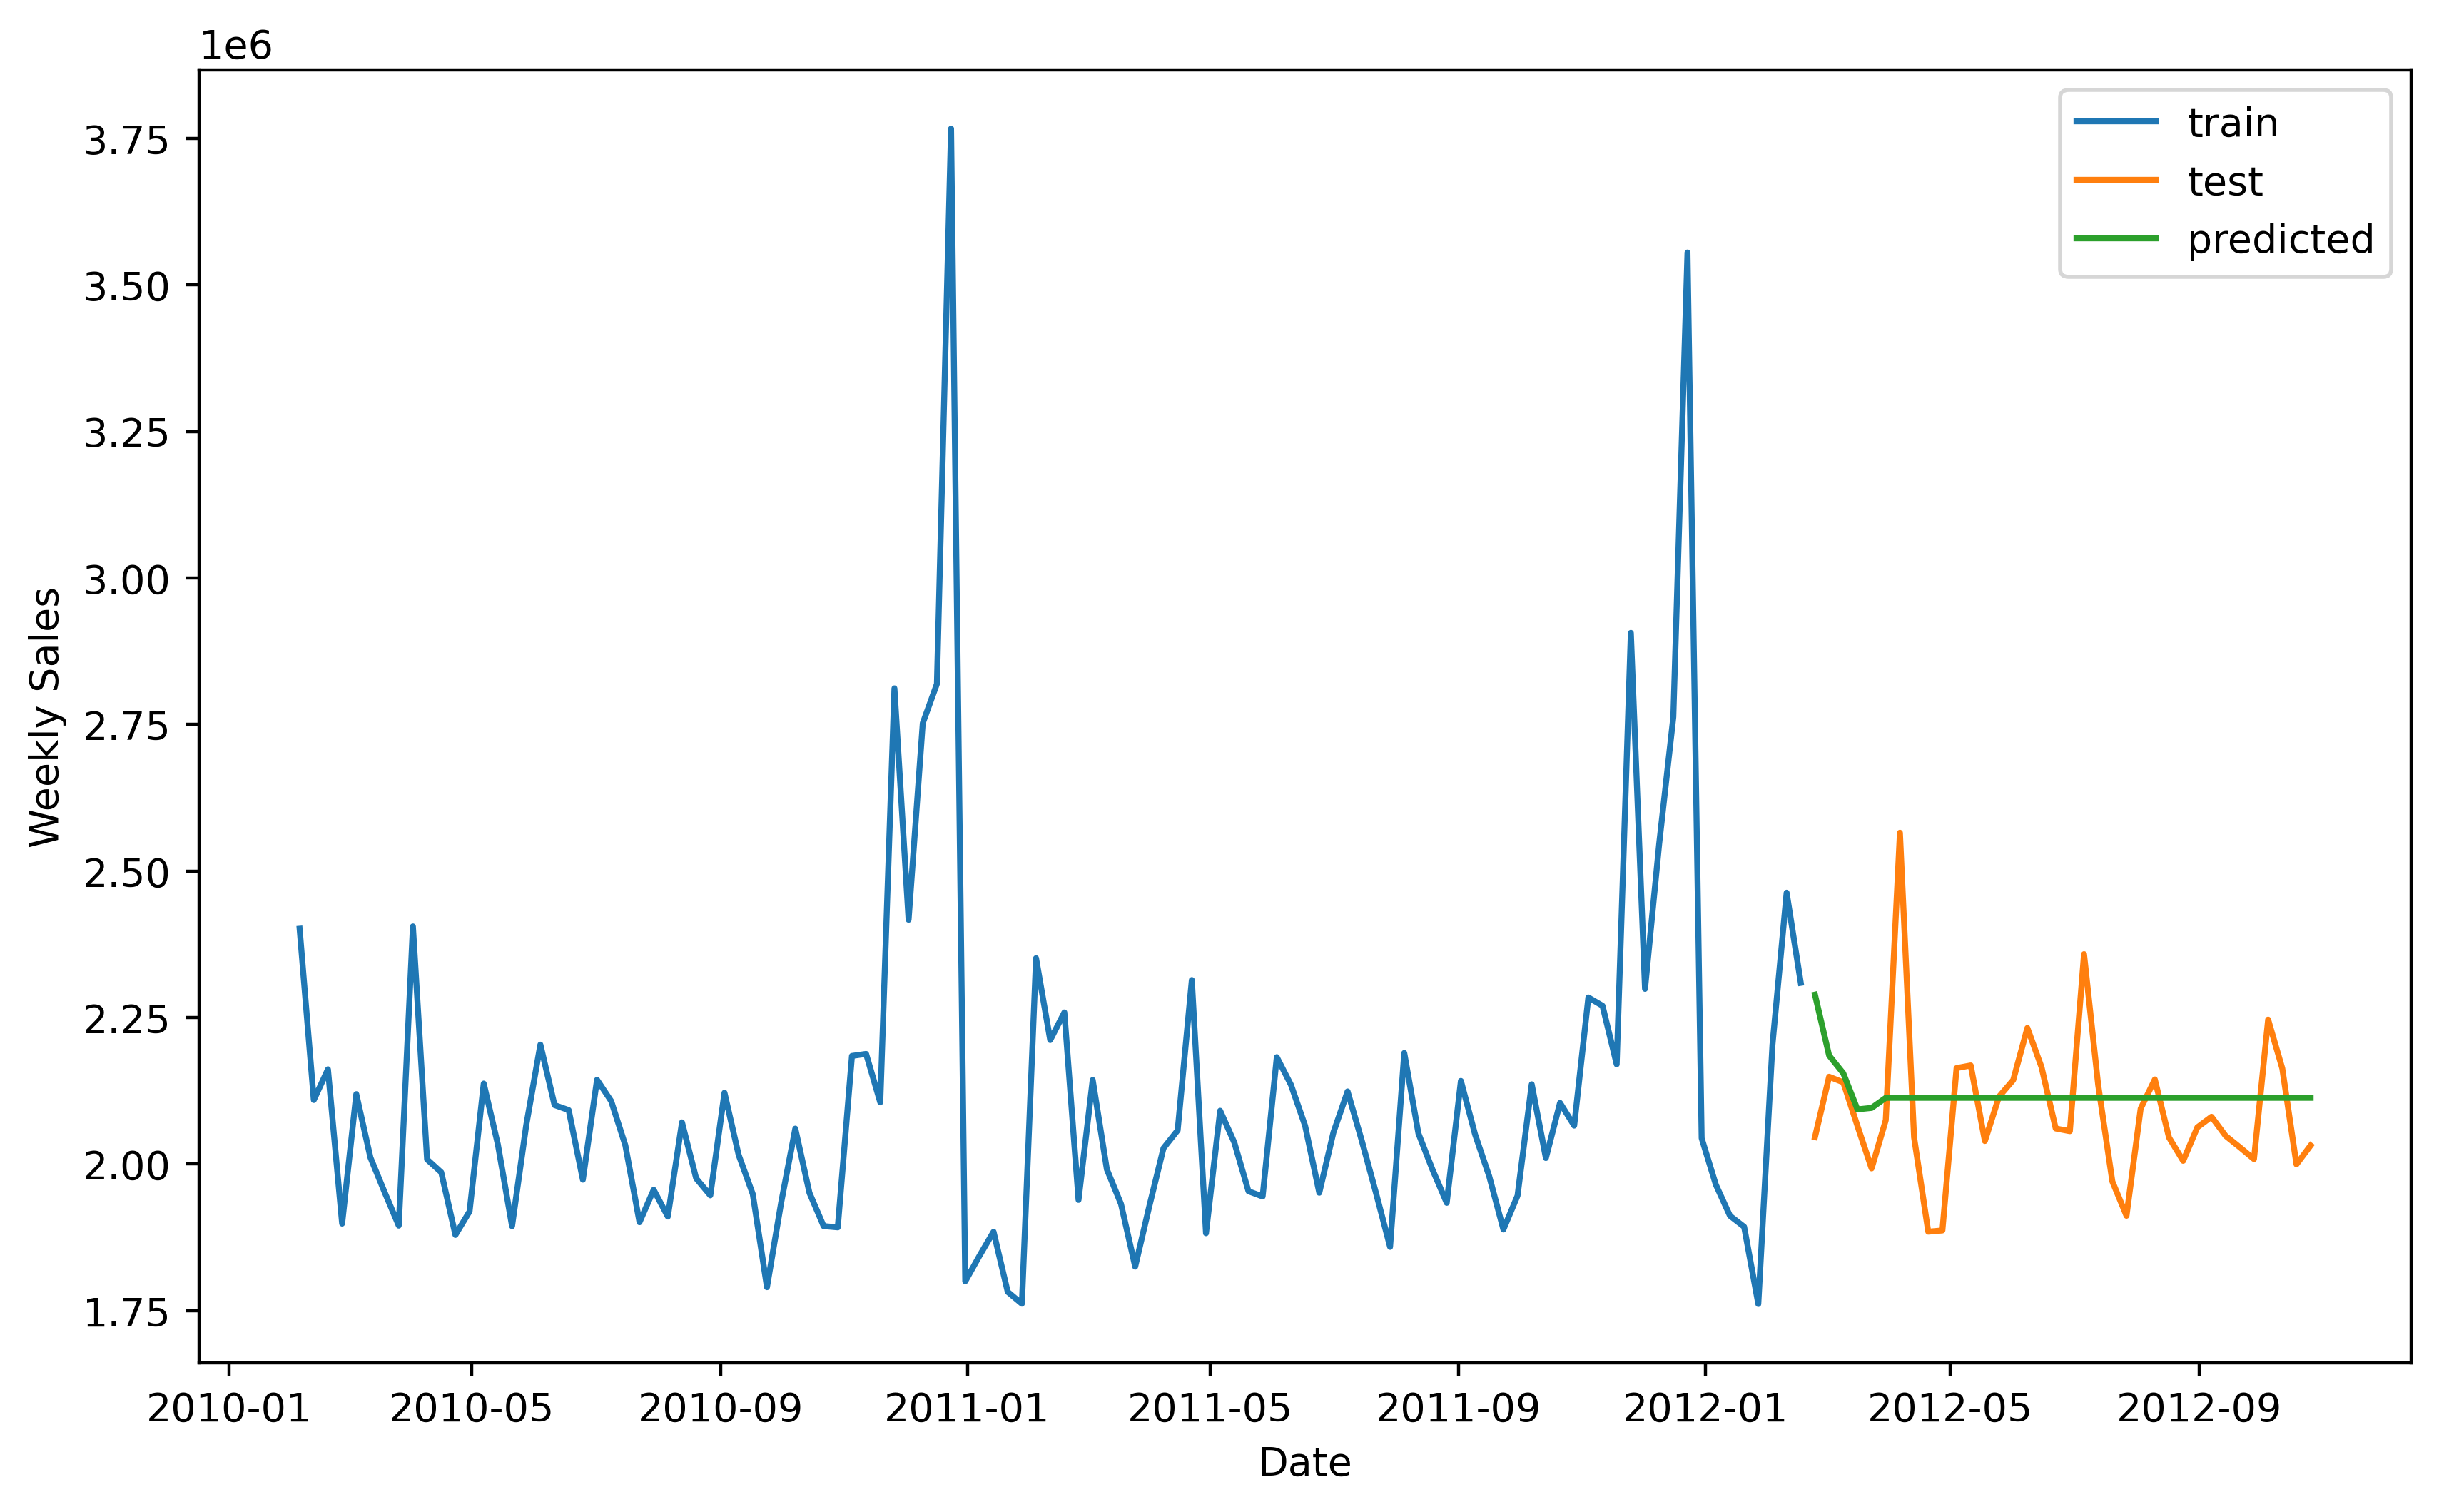

In [86]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = "train")
plt.plot(test, label = "test");
plt.plot(yhat_arima, label = "predicted")
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.legend();

## Seasonal ARIMA (SARIMA)

In [259]:
import itertools
import statsmodels.api as sm

# Define Parameter Ranges to Test
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

#Run Grid Search
def gridsearch_sarima(train, pdq, pdqs):
    '''
    Input: 
        train : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        
    Return:
        Prints the AIC value for each combination
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    count = 1
    for i in pdq:
        for j in pdqs:
            if count == 20:
                return 
            mod = sm.tsa.statespace.SARIMAX(train, order=i, seasonal_order=j)
            output = mod.fit() 
            ans.append([i, j, output.bic])
            print(count, 'SARIMAX {} x {}12 : AIC Calculated ={}'.format(i, j, output.aic))
            count += 1

In [260]:
# Tried using grid search for finding the best hyper parameters but it is taking to long to run for all the combinations, so ran for the first 20 iterations.
gridsearch_sarima(train, pdq, pdqs)

1 SARIMAX (0, 0, 0) x (0, 0, 0, 52)12 : AIC Calculated =3424.5243839532304
2 SARIMAX (0, 0, 0) x (0, 0, 1, 52)12 : AIC Calculated =3671.8824639054974
3 SARIMAX (0, 0, 0) x (0, 0, 2, 52)12 : AIC Calculated =3453.8645786645266
4 SARIMAX (0, 0, 0) x (0, 1, 0, 52)12 : AIC Calculated =1471.7874800828686
5 SARIMAX (0, 0, 0) x (0, 1, 1, 52)12 : AIC Calculated =1458.0476972917756
6 SARIMAX (0, 0, 0) x (0, 1, 2, 52)12 : AIC Calculated =1459.7731495342146
7 SARIMAX (0, 0, 0) x (0, 2, 0, 52)12 : AIC Calculated =97.08227108911626
8 SARIMAX (0, 0, 0) x (0, 2, 1, 52)12 : AIC Calculated =82.08925462143377
9 SARIMAX (0, 0, 0) x (0, 2, 2, 52)12 : AIC Calculated =83.12171111554852
10 SARIMAX (0, 0, 0) x (1, 0, 0, 52)12 : AIC Calculated =3121.4193344846826
11 SARIMAX (0, 0, 0) x (1, 0, 1, 52)12 : AIC Calculated =3170.818749062019
12 SARIMAX (0, 0, 0) x (1, 0, 2, 52)12 : AIC Calculated =3172.4050399439598
13 SARIMAX (0, 0, 0) x (1, 1, 0, 52)12 : AIC Calculated =1483.955305762956
14 SARIMAX (0, 0, 0) x (1,

In [96]:
sarimax = sm.tsa.statespace.SARIMAX(train, order=(0,1,1), seasonal_order=(0, 1, 1, 52)).fit() # lags = 0, differencing = 1, moving average = 1, seasonal value = 52
yhat_sarima = results(sarimax, test, store20)

Mean absolute percentage error - 3.9 %


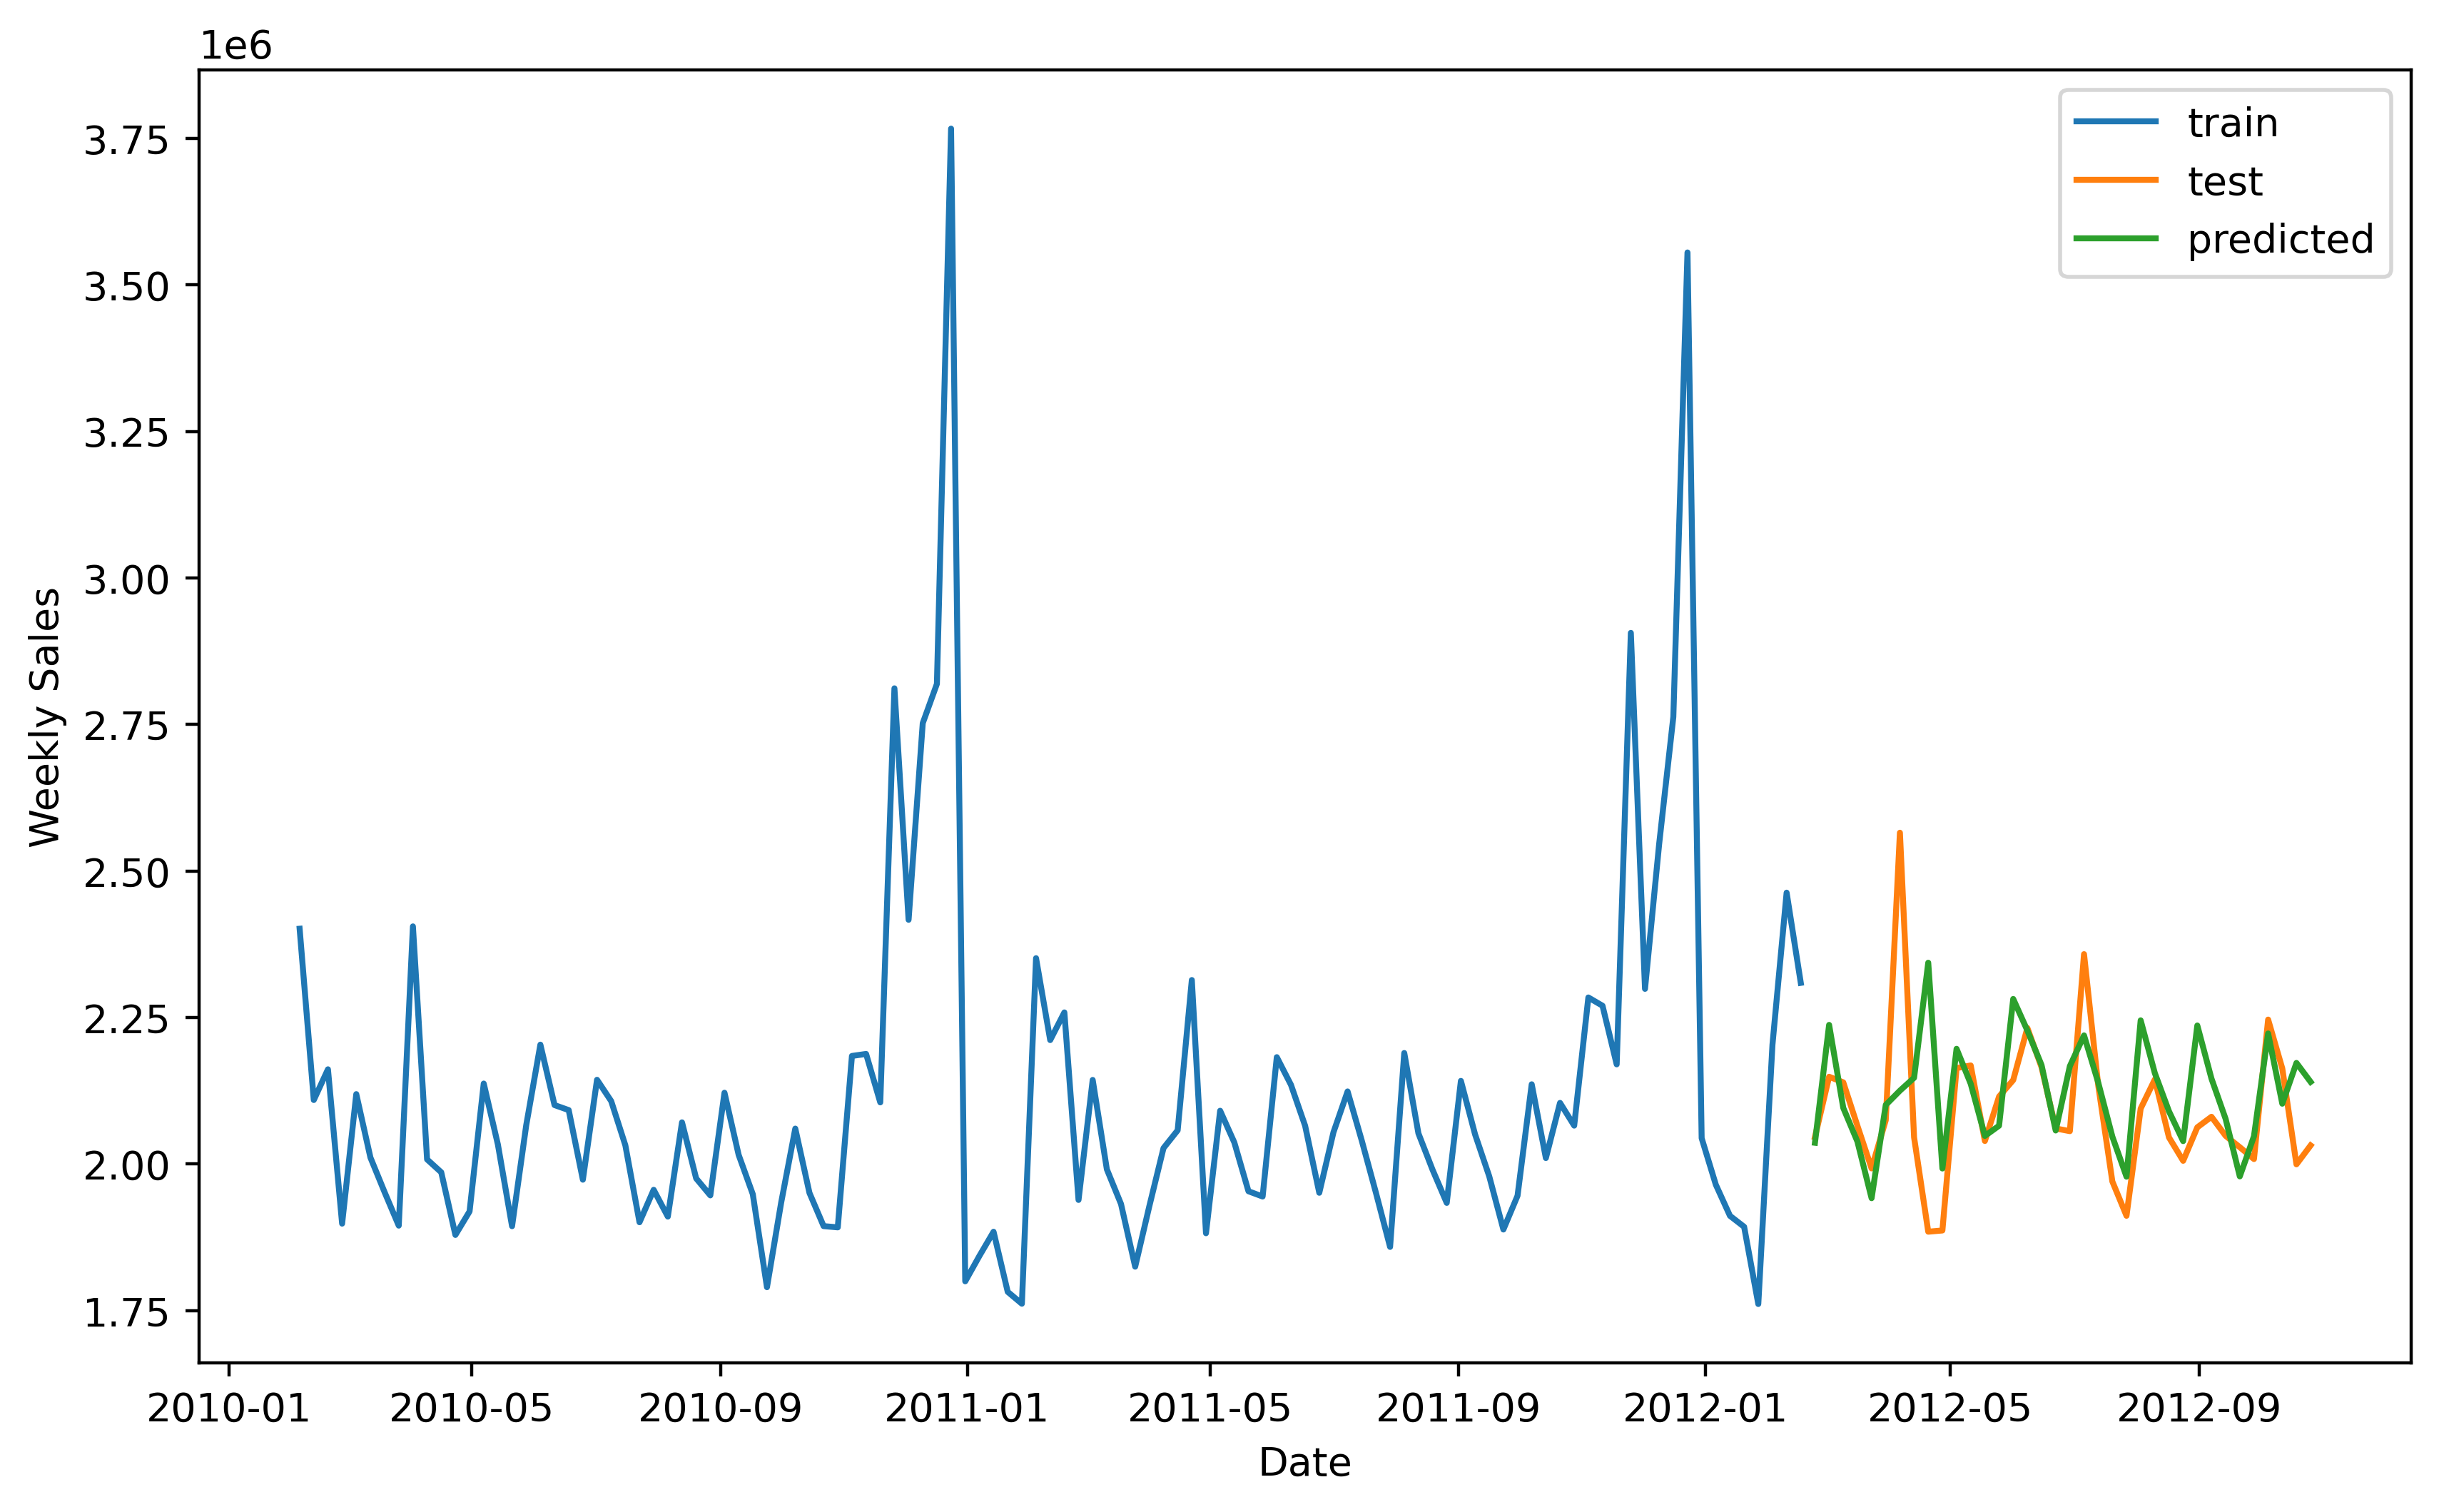

In [95]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = "train")
plt.plot(test, label = "test");
plt.plot(yhat_sarima, label = "predicted")
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.legend();

## ExponentialSmoothing

In [101]:
model_holt_winters = ExponentialSmoothing(train, seasonal_periods = 52, seasonal = 'additive', trend = 'additive').fit()
yhat_exp = model_holt_winters.forecast(len(test))
print("Mean absolute percentage error -", np.round((abs(yhat_exp - test['Weekly_Sales'])/ test['Weekly_Sales'] * 100).mean(), 1), "%")

Mean absolute percentage error - 4.4 %


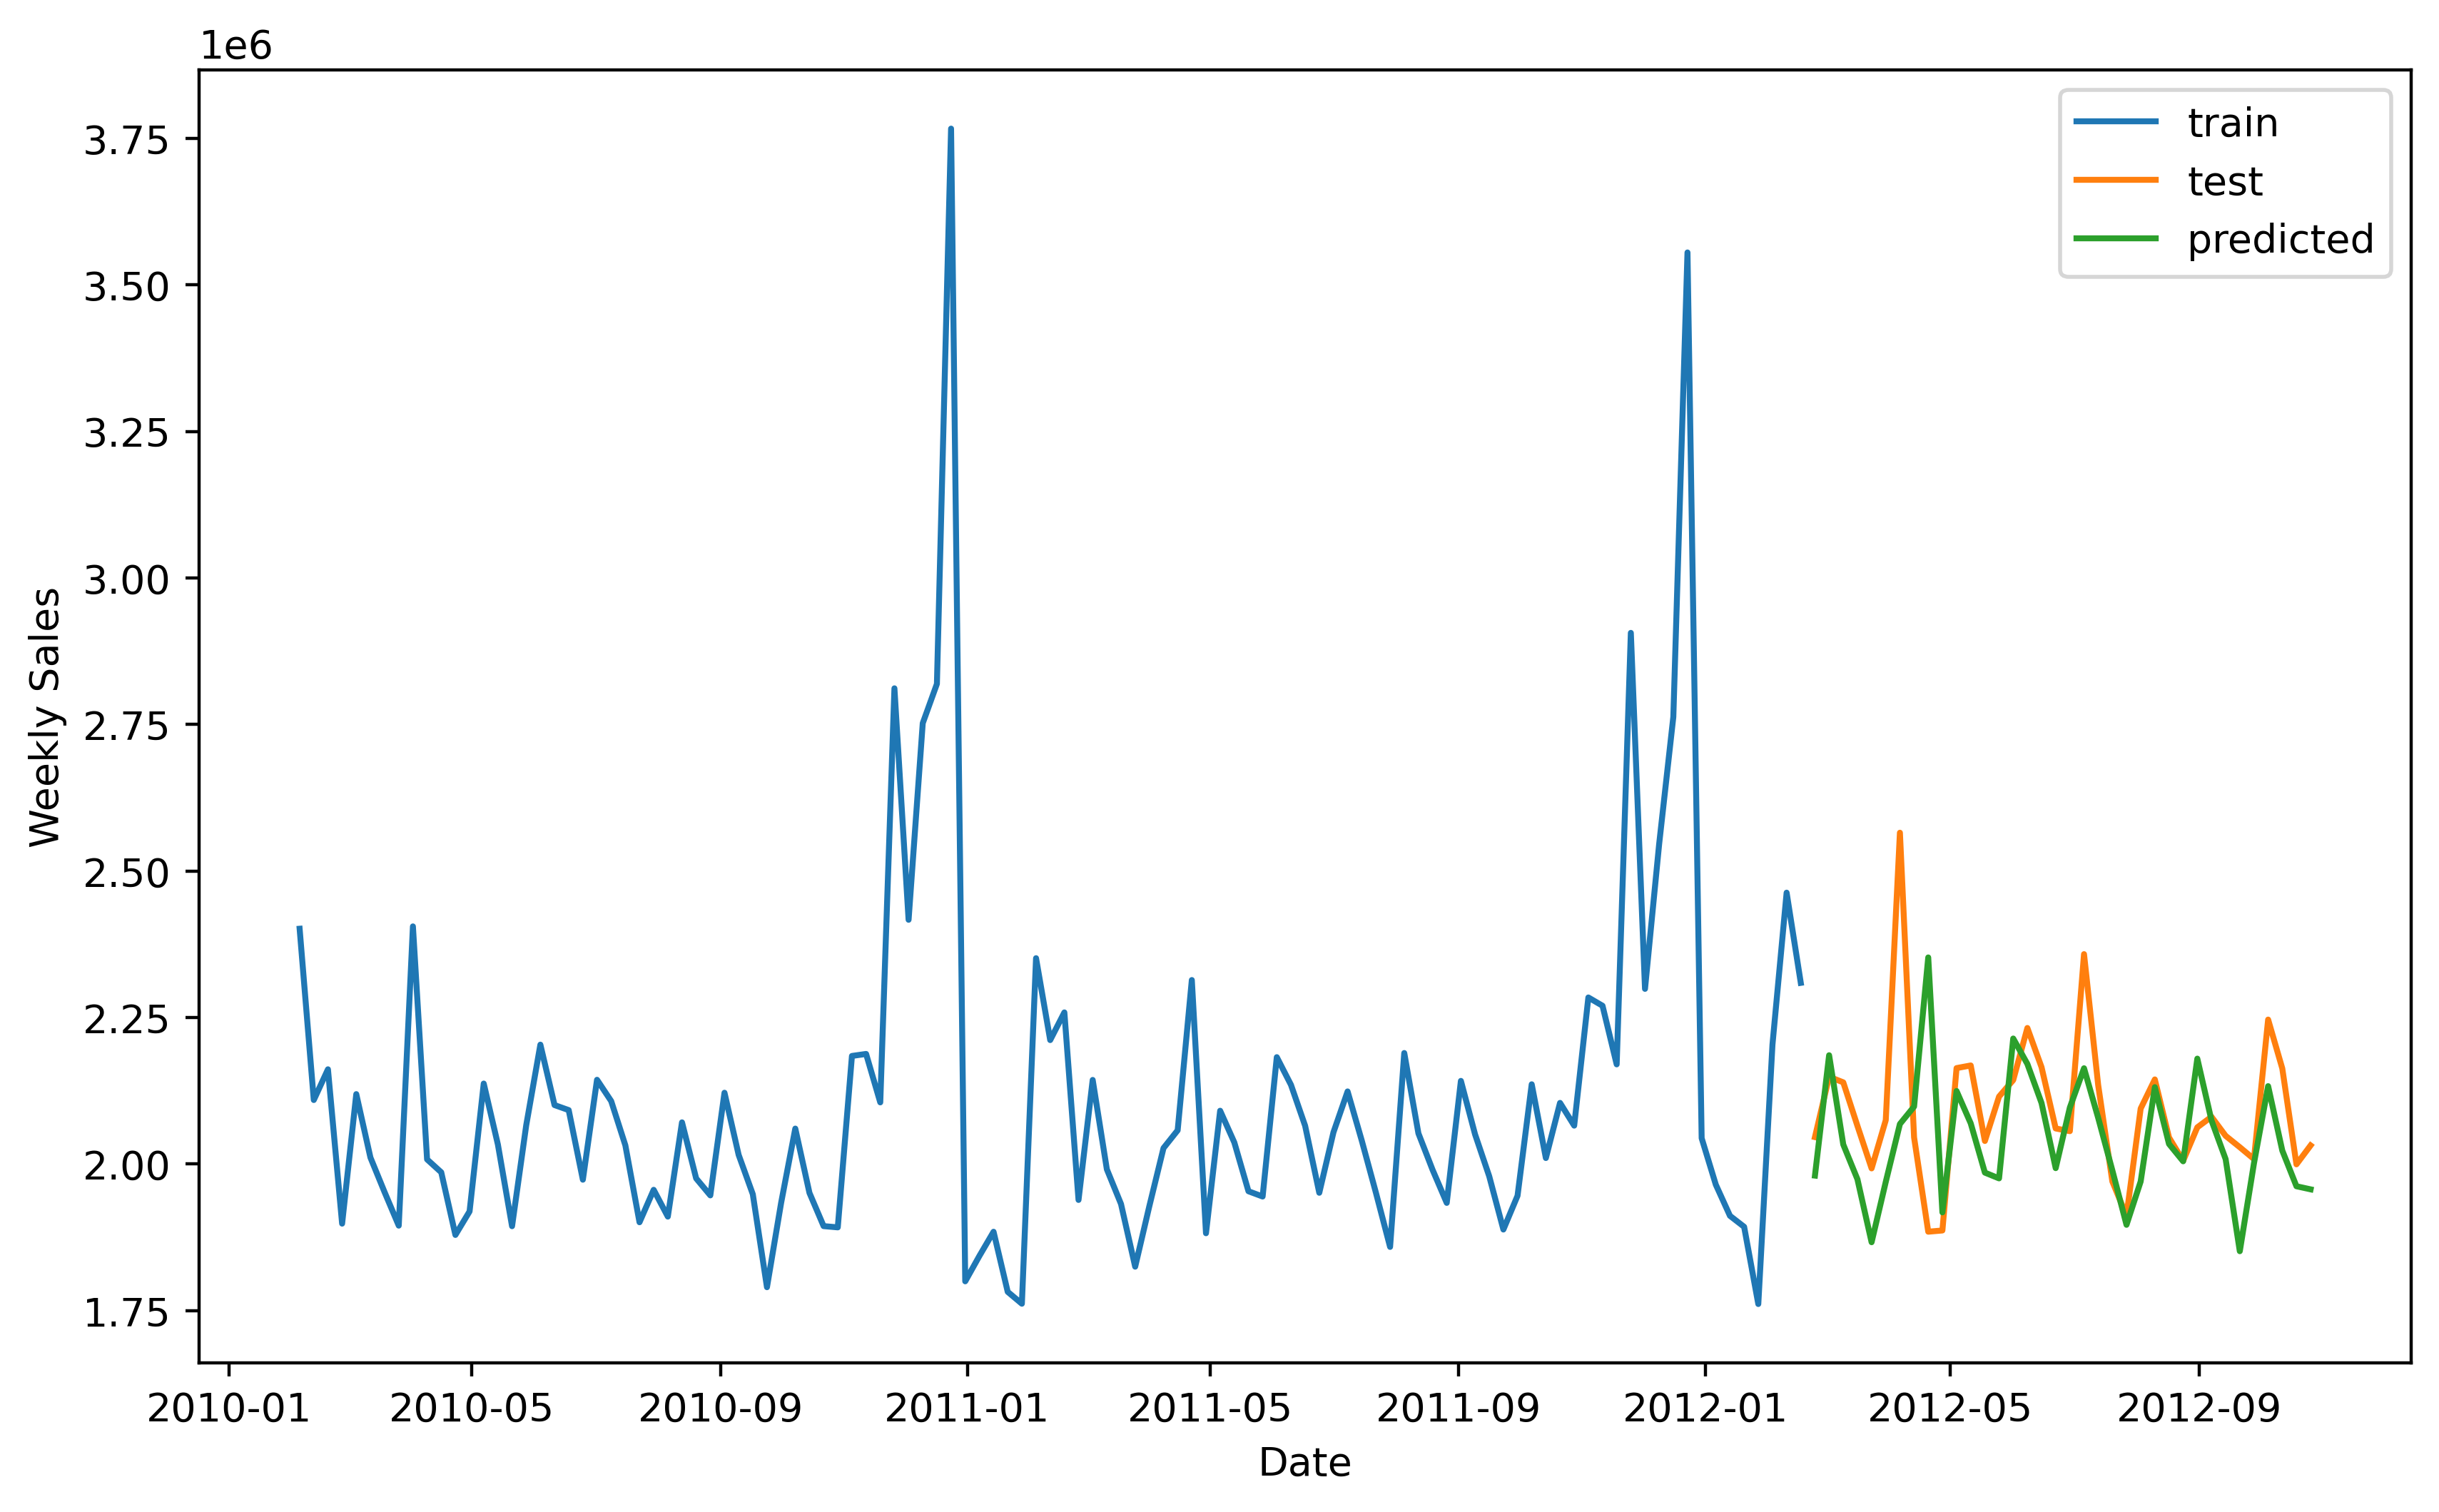

In [102]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = "train")
plt.plot(test, label = "test");
plt.plot(yhat_exp, label = "predicted")
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.legend();

## Univariate Analysis for store 4

In [261]:
#Taking only the store 4 sales data
store4 = univ_df[univ_df['Store'] == 4]
store4.drop('Store', axis = 1, inplace = True)
store4.head()

Weekly_Sales
Date                    
2010-02-05    2135143.87
2010-02-12    2188307.39
2010-02-19    2049860.26
2010-02-26    1925728.84
2010-03-05    1971057.44

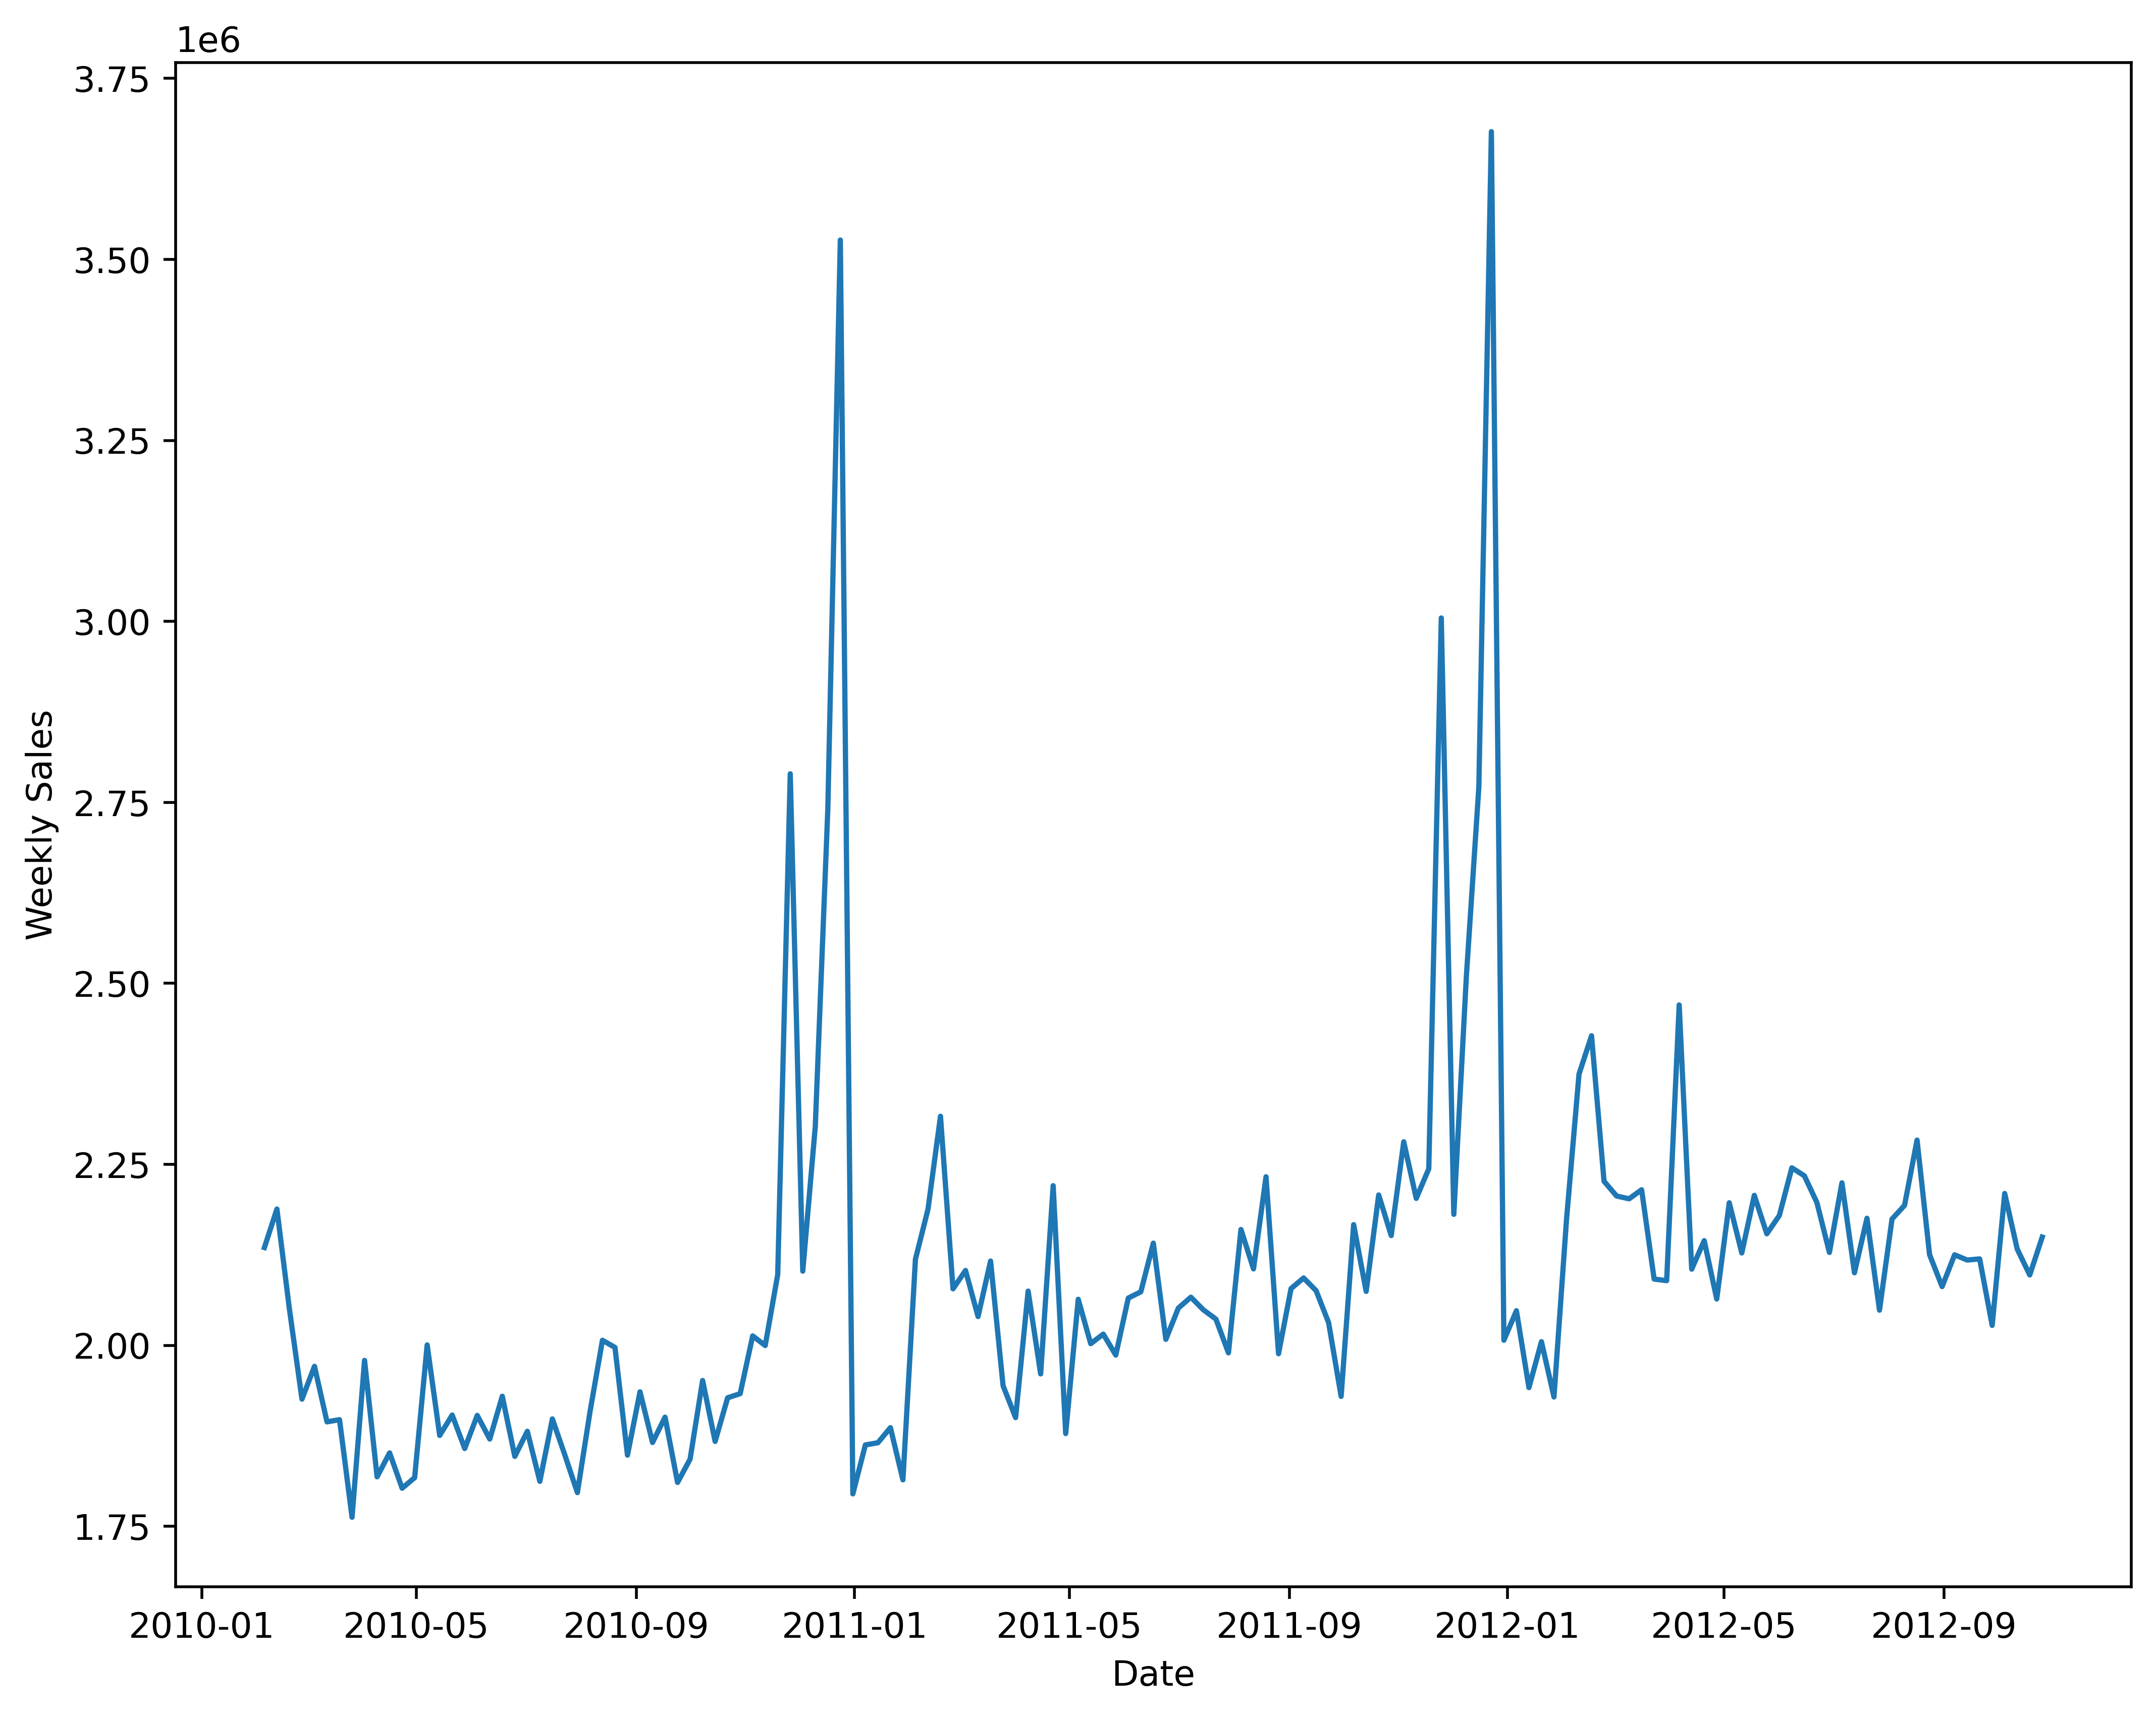

In [262]:
plt.figure(figsize = (10,8), dpi = 500)
plt.plot(store4)
plt.ylabel("Weekly Sales")
plt.xlabel("Date");

# Splitting the data into 75% train and 25% test data

In [265]:
train, test = train_test_split(store4, test_size = 0.25, shuffle = False)

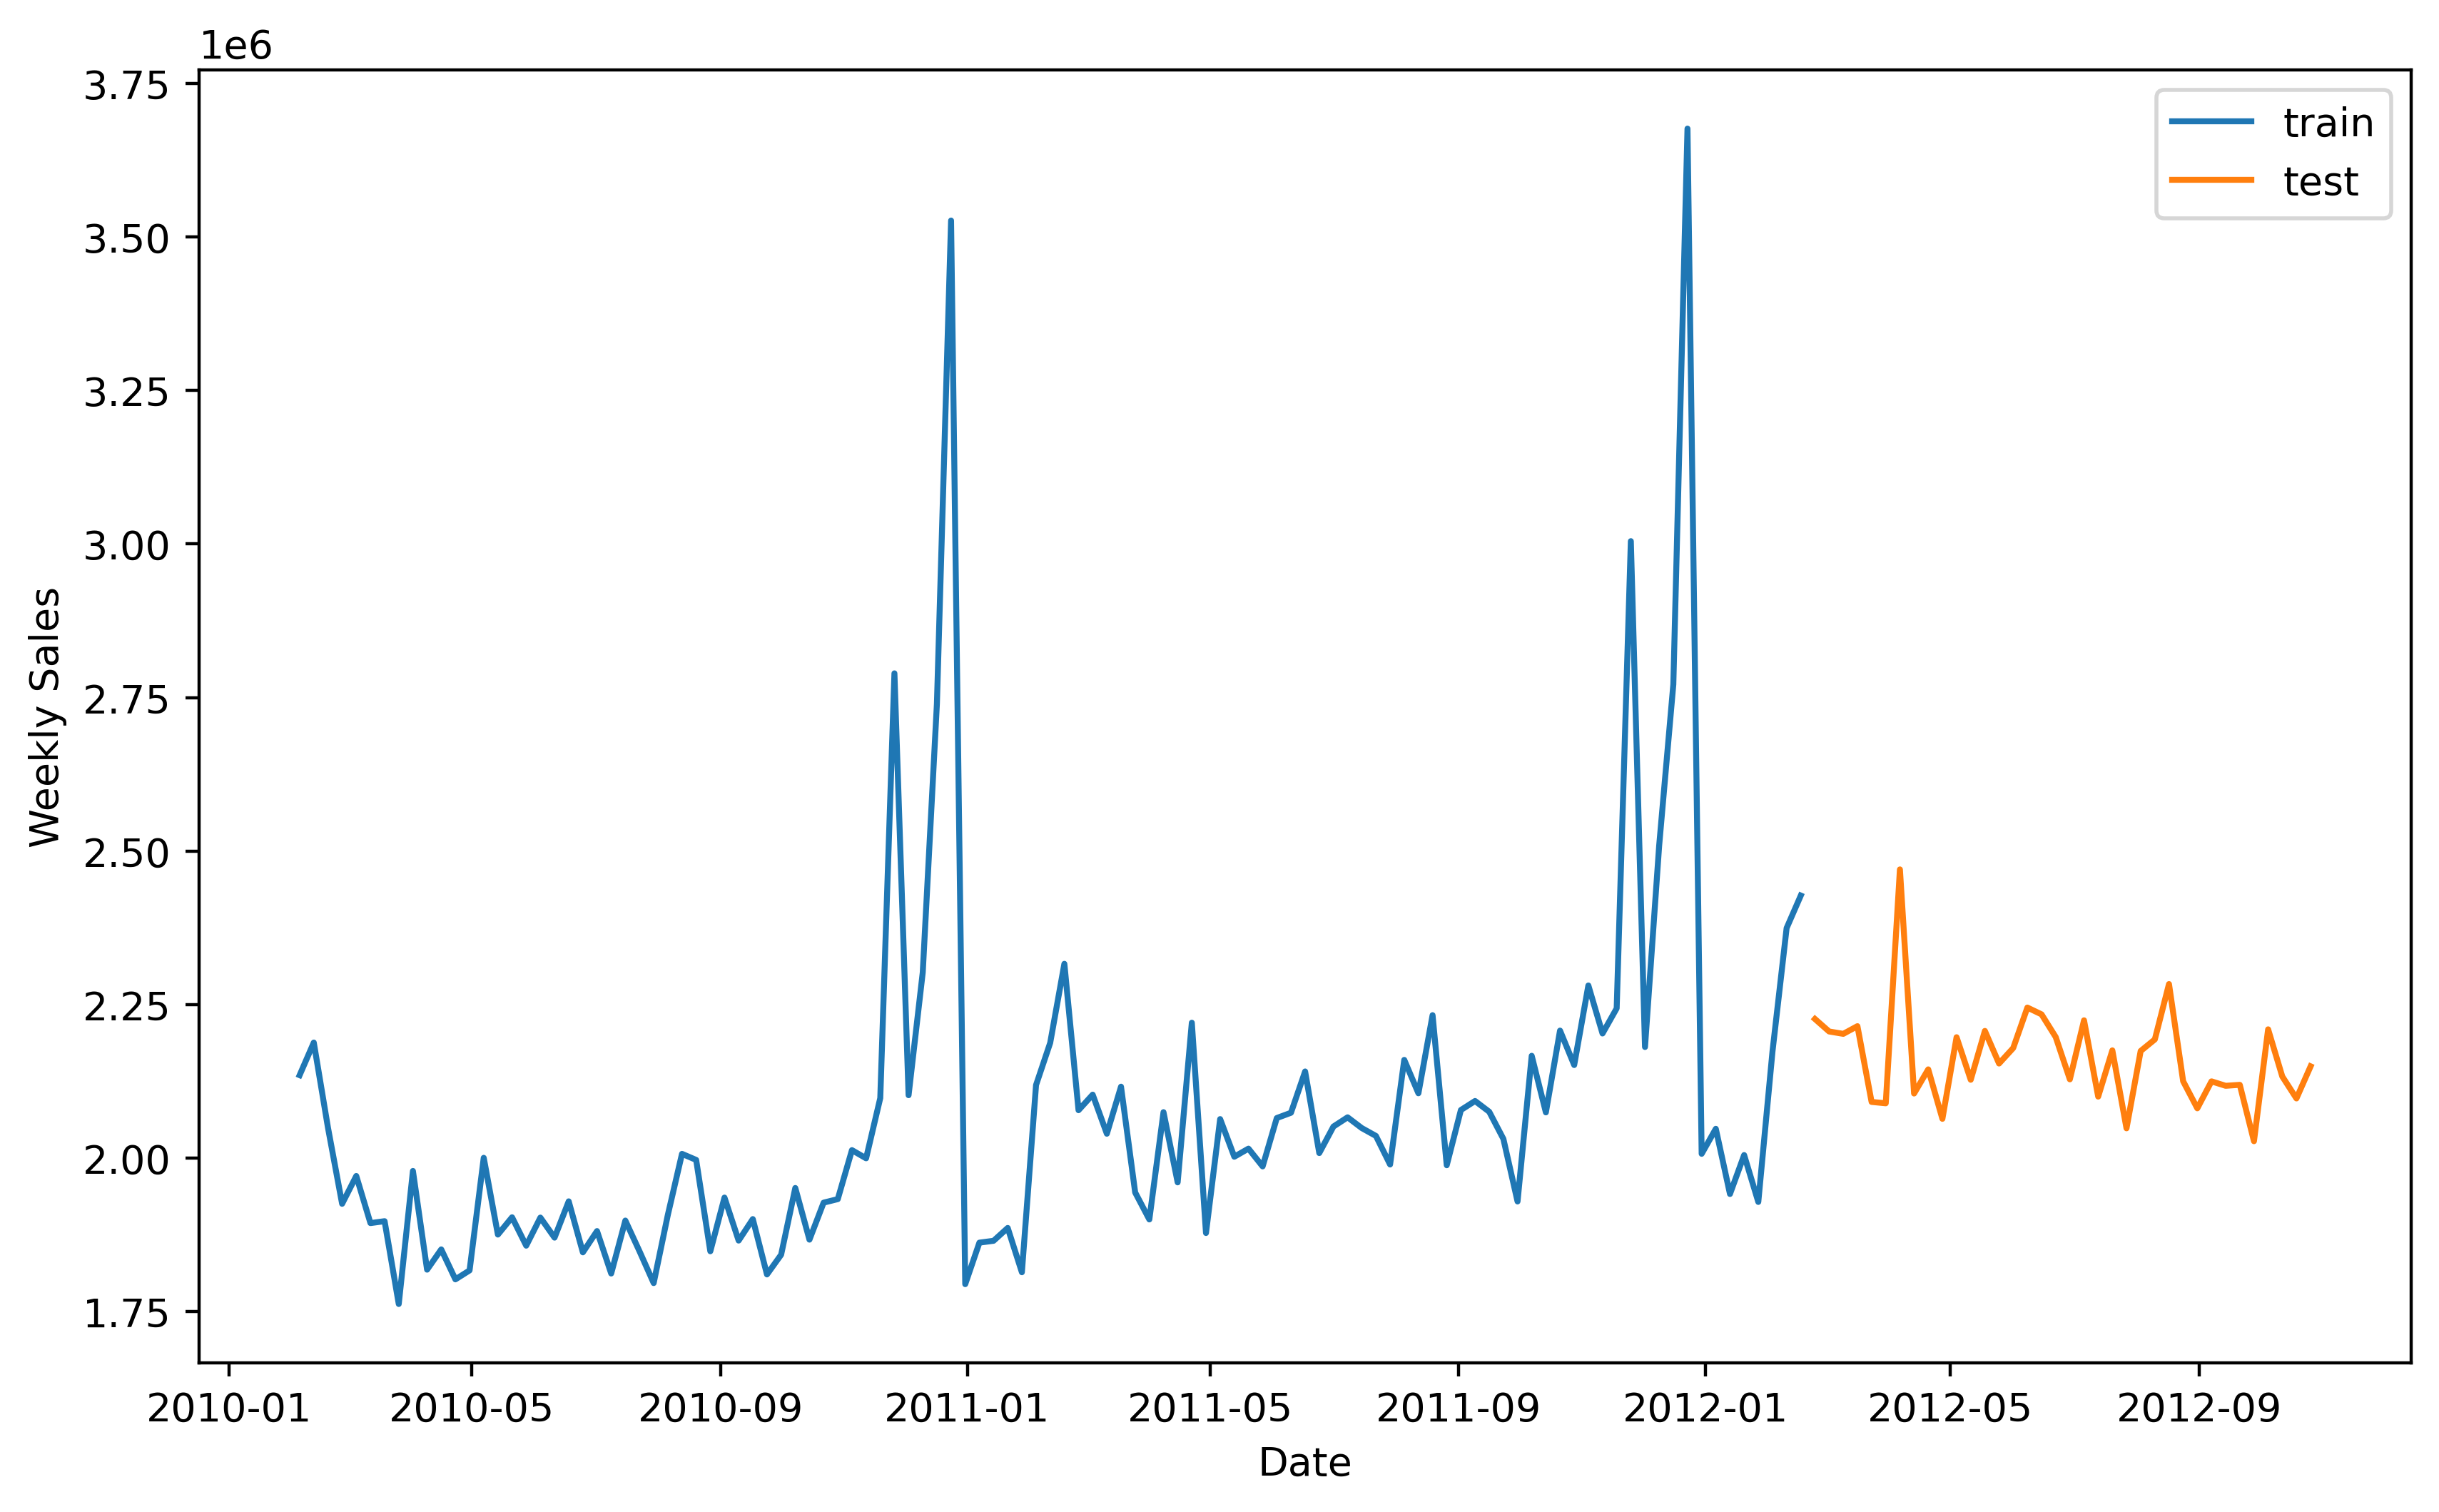

In [266]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.legend()
plt.ylabel("Weekly Sales")
plt.xlabel("Date");

# Checking for autocorrelation for 52 lags

(-0.5, 0.5)

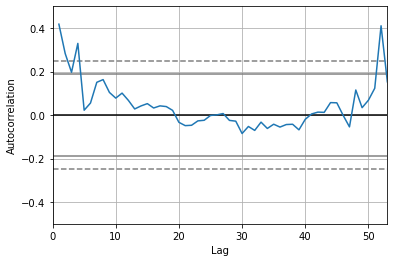

In [117]:
autocorrelation_plot(train["Weekly_Sales"])
plt.xlim(0,53)
plt.ylim(-0.5, 0.5)

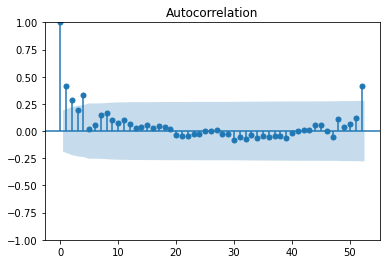

In [118]:
#Autocorrelation Function (ACF)
plot_acf(train['Weekly_Sales'], lags = 52);

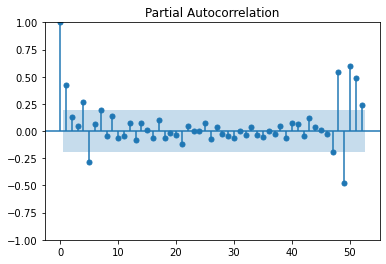

In [119]:
# Partial autocorrelation function (PACF) 
plot_pacf(train['Weekly_Sales'], lags = 52);

In [120]:
print("1 week", train['Weekly_Sales'].autocorr(lag = 1))
print("2 week", train['Weekly_Sales'].autocorr(lag = 2))
print("3 week", train['Weekly_Sales'].autocorr(lag = 3))
print("1 month", train['Weekly_Sales'].autocorr(lag = 4))
print("2 months", train['Weekly_Sales'].autocorr(lag = 8))
print("3 months", train['Weekly_Sales'].autocorr(lag = 12))
print("1 year", train['Weekly_Sales'].autocorr(lag = 50))

1 week 0.4209156787007822
2 week 0.2862398145745118
3 week 0.19937965232314514
1 month 0.33473190313131485
2 months 0.16768122371736788
3 months 0.09500953040470864
1 year 0.2097788054450121


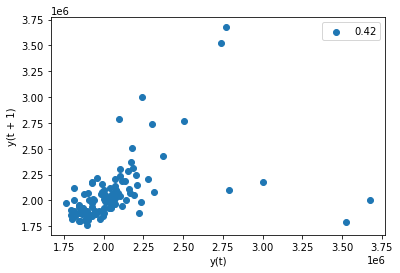

In [121]:
# Plotting the auto correlation for lag = 1
pd.plotting.lag_plot(train['Weekly_Sales'], lag = 1)
plt.legend([np.round(train['Weekly_Sales'].autocorr(lag = 1), 2).astype('str')])

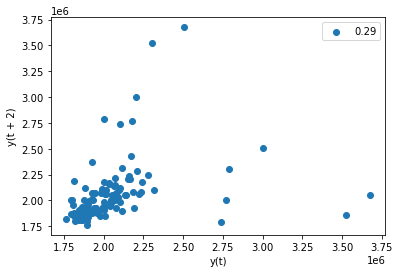

In [122]:
# Plotting the auto correlation for lag = 2
pd.plotting.lag_plot(train['Weekly_Sales'], lag = 2)
plt.legend([np.round(train['Weekly_Sales'].autocorr(lag = 2), 2).astype('str')])

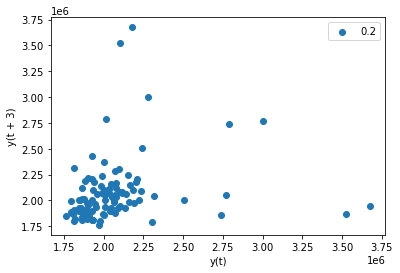

In [123]:
# Plotting the auto correlation for lag = 3
pd.plotting.lag_plot(train['Weekly_Sales'], lag = 3)
plt.legend([np.round(train['Weekly_Sales'].autocorr(lag = 3), 2).astype('str')])

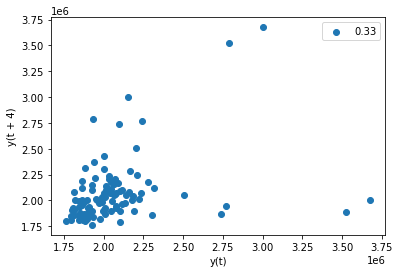

In [124]:
# Plotting the auto correlation for lag = 4
pd.plotting.lag_plot(train['Weekly_Sales'], lag = 4)
plt.legend([np.round(train['Weekly_Sales'].autocorr(lag = 4), 2).astype('str')])

## From the above graphs, we can say that lag 4 has the best correlation

# Checking for stationarity using Augmented Dickey Fuller test

In [267]:
test_stationarity(train)

Results of Dickey-Fuller Test:
Test Statistic                  -3.509825
p-value                          0.007738
#Lags Used                       4.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


## From the above test results, as the p value is less than 0.05, we can say that with 95% confidence interval our data is stationary

# Modeling

## Auto Regression 

In [268]:
# Chose the lags =4 from the above PACF plot
autoreg = AutoReg(train, lags = 4).fit()
yhat_reg = results(autoreg, test, store4)

Mean absolute percentage error - 3.3 %


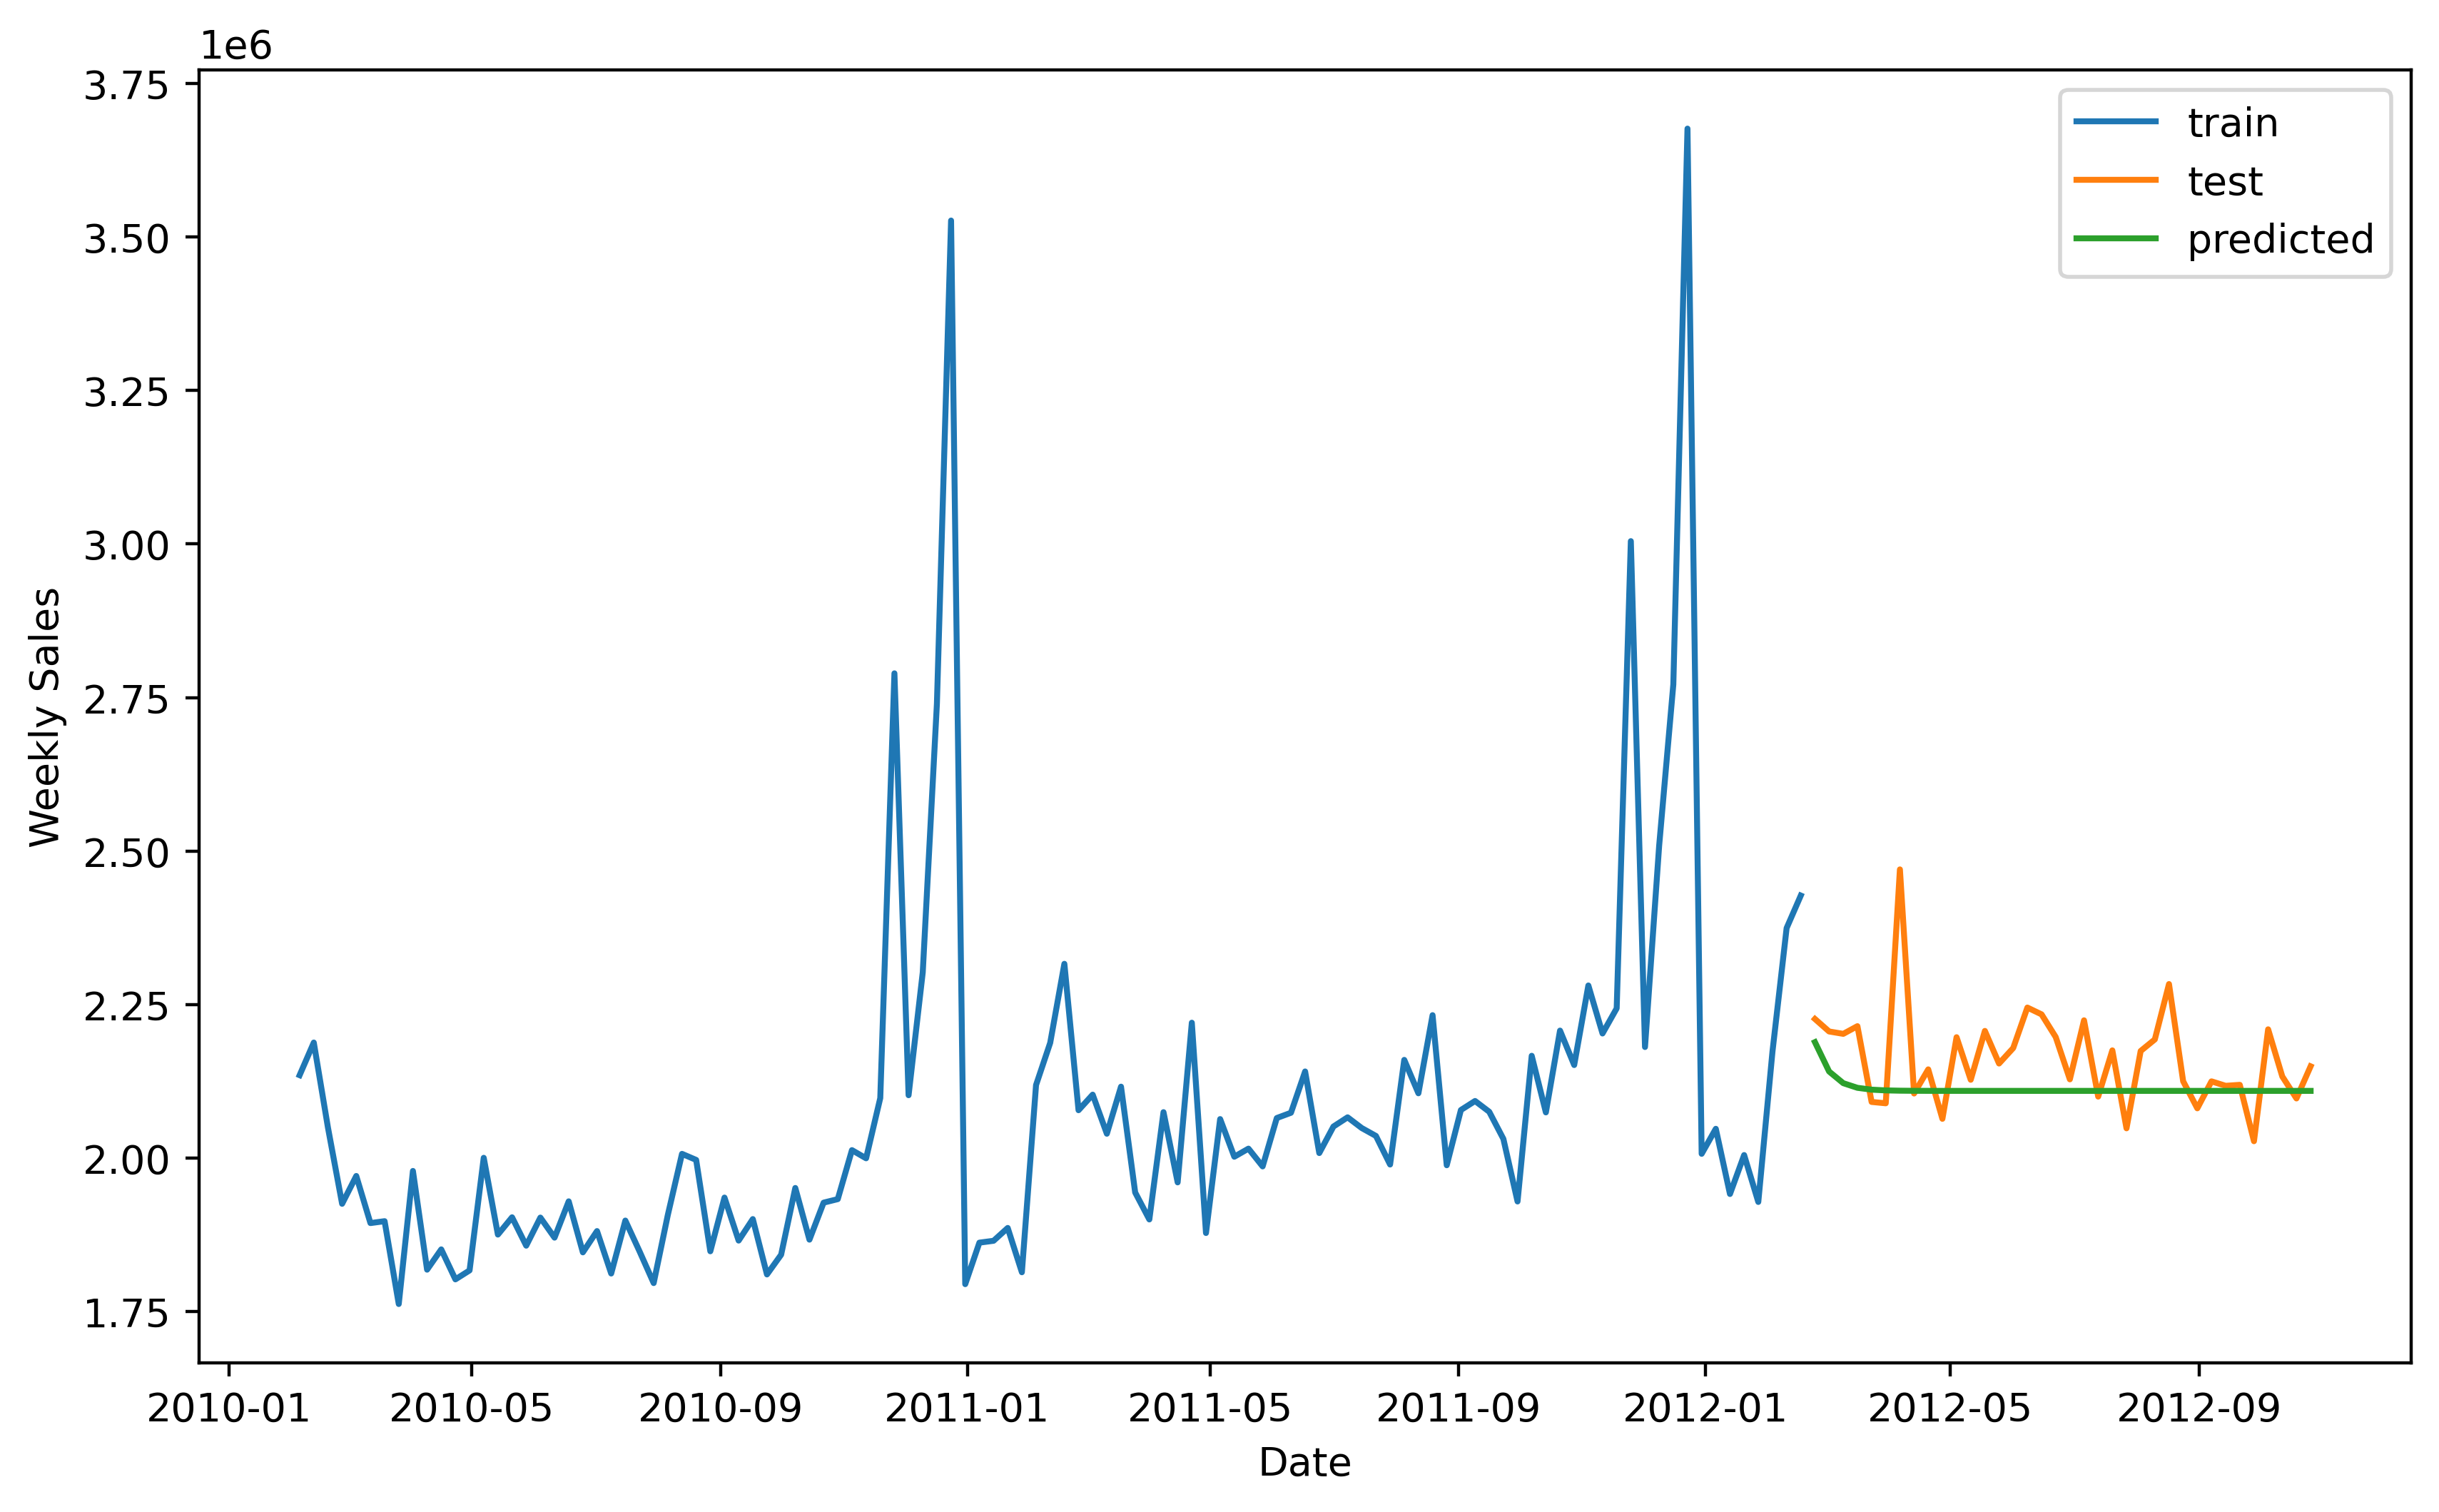

In [127]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = "train")
plt.plot(test, label = "test");
plt.plot(yhat_autoreg, label = "predicted")
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.legend();

## Auto Arima

In [140]:
# Running auto arima to find the best hyper parameterts for arima model
model_auto_arima = auto_arima(train, trace = True, start_p = 0, start_q = 0, start_P = 0, start_Q = 0,
                  max_p = 30, max_q = 30, max_P = 30, max_Q = 30, seasonal = True, maxiter = 200,
                  information_criterion = 'aic', stepwise = False, suppress_warnings = True, D = 1, max_D = 10,
                  error_action = 'ignore',approximation = False)
model_auto_arima.fit(train)
start_test = test.index[0]
end_test = test.index[-1]
yhat_test = model_auto_arima.predict(n_periods = len(test))

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=2994.114, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=2978.060, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2973.149, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2973.398, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2973.033, Time=0.06 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2970.017, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2984.964, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=2969.623, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=2972.849, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2966.344, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2968.553, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2983.164, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2971.365, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2970.725, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2965.528, Time=0.14 sec
 ARIMA(3,1

## Autoregressive integrated moving average(ARIMA)


In [269]:
arima = ARIMA(train, order = (1, 0, 3)).fit()
yhat_arima = results(arima, test, store4)

Mean absolute percentage error - 3.3 %


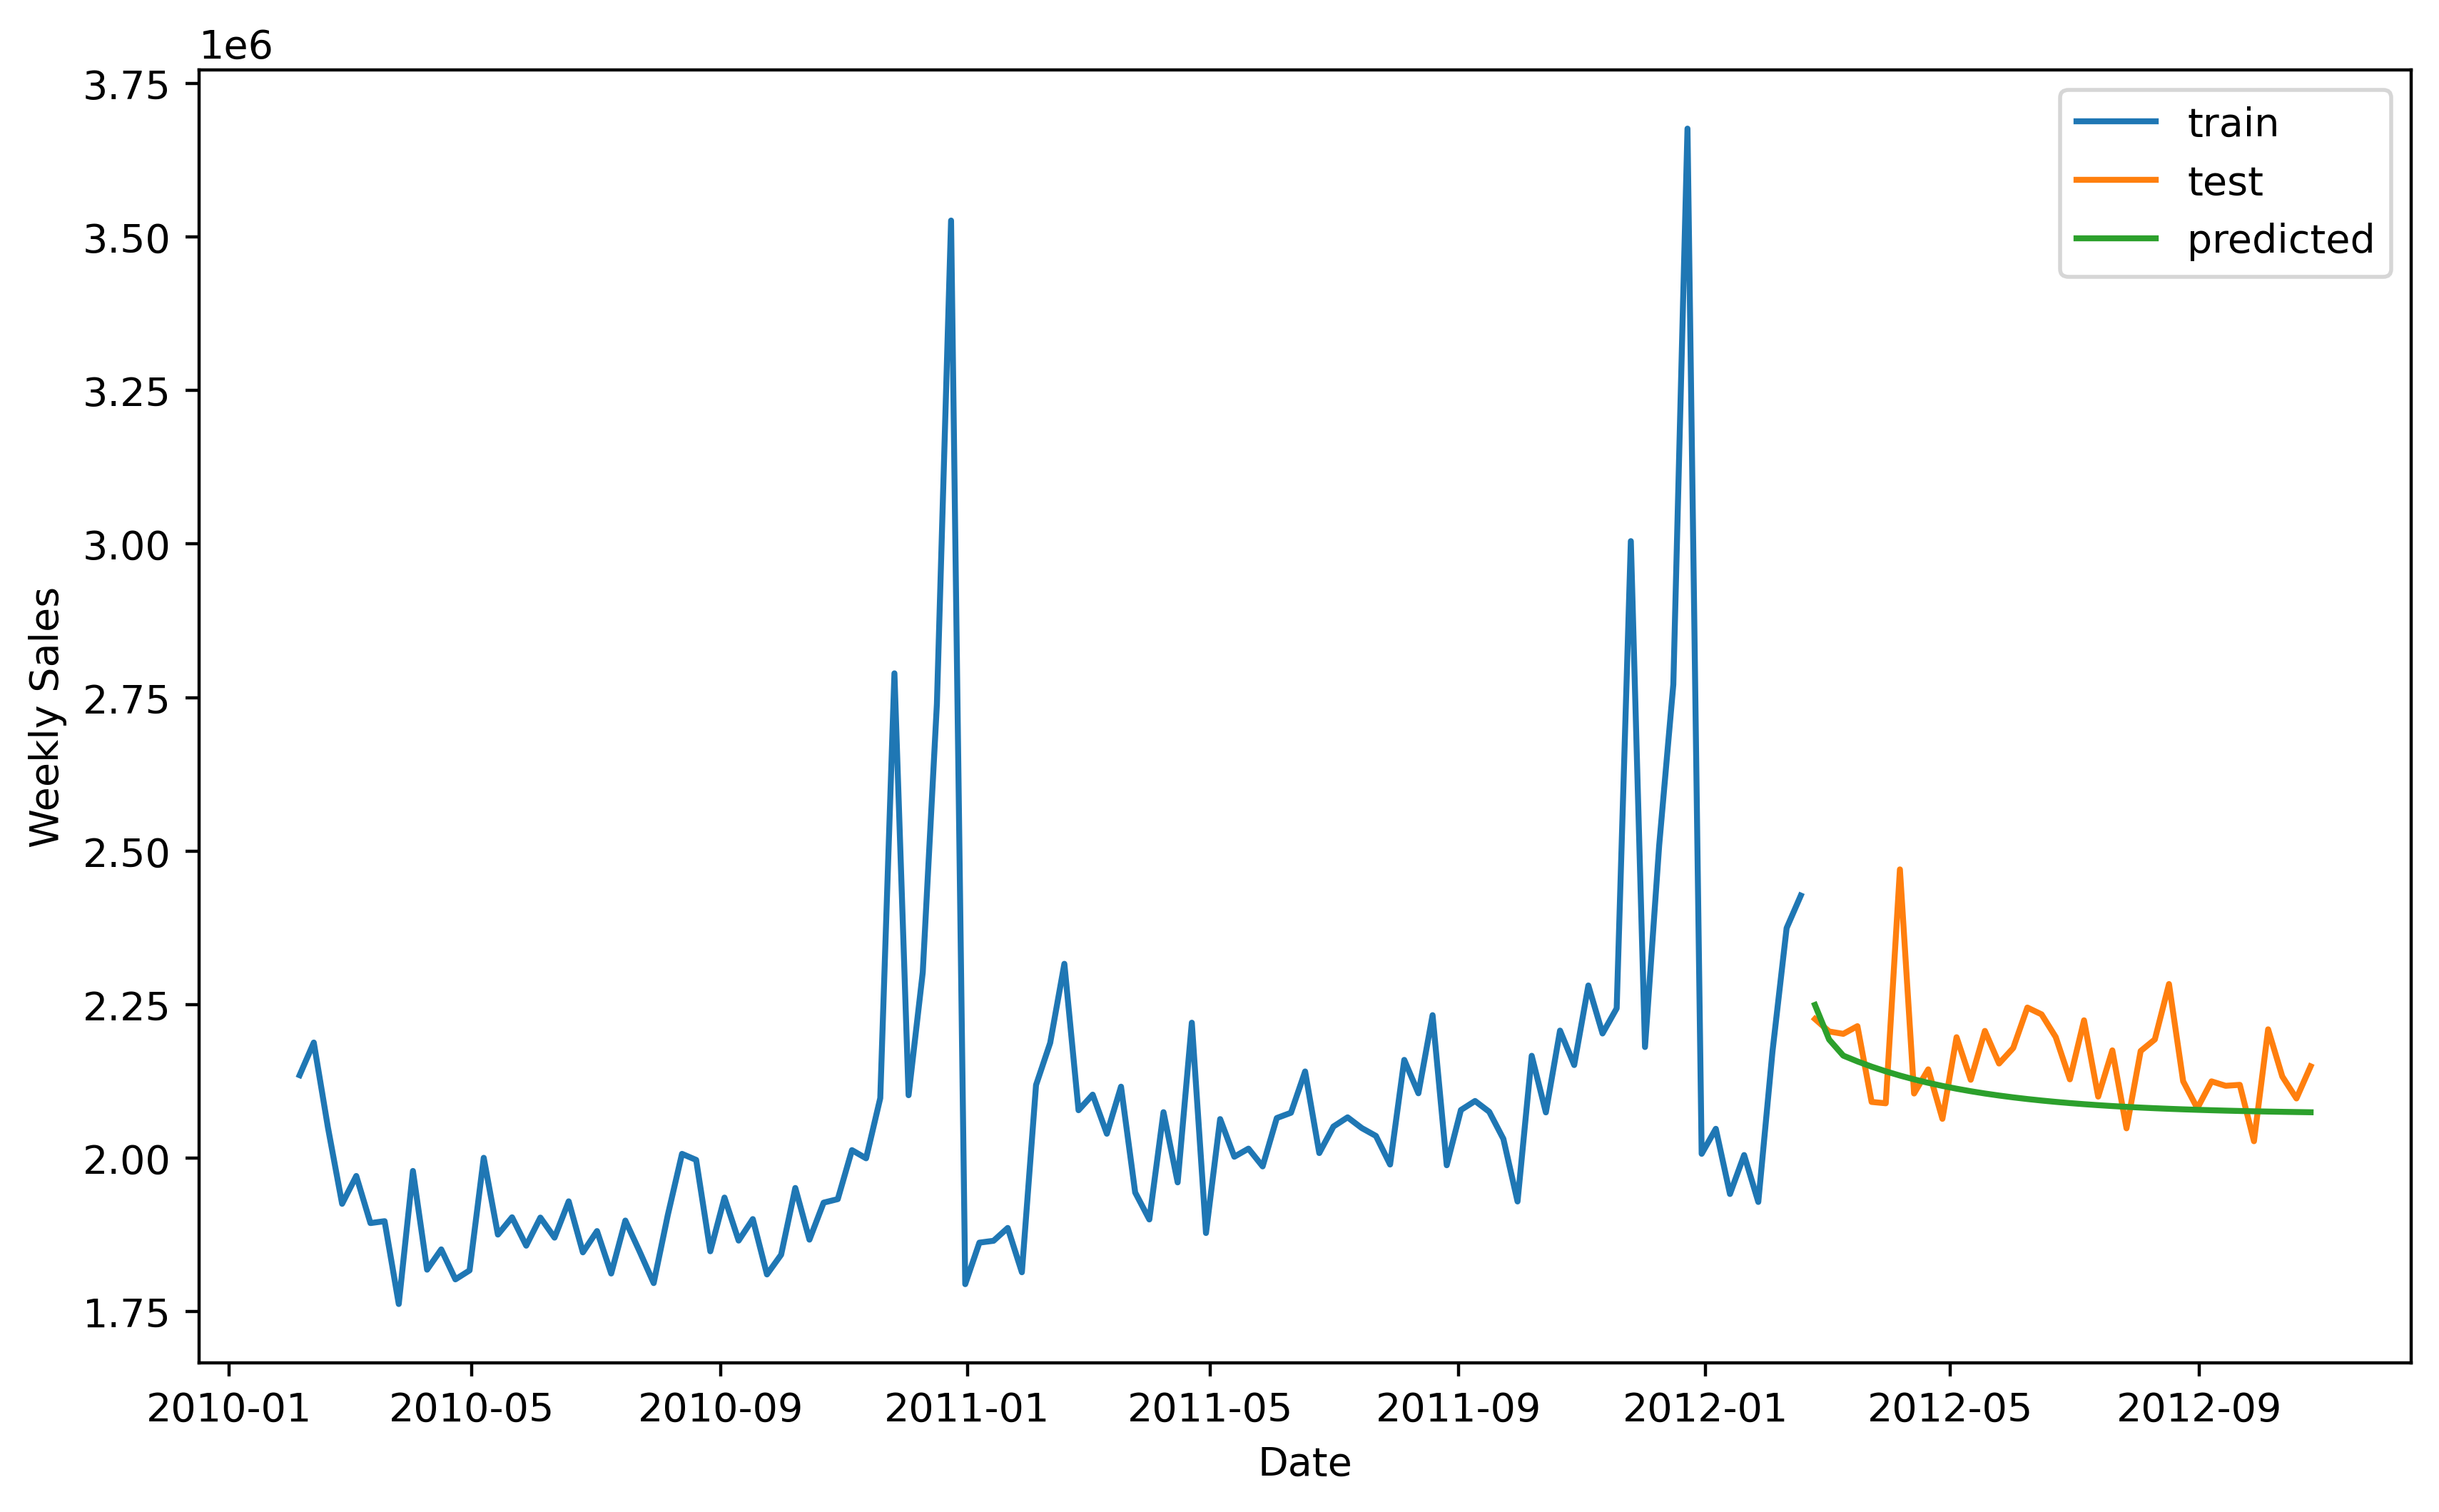

In [141]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = "train")
plt.plot(test, label = "test");
plt.plot(yhat_arima, label = "predicted")
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.legend();

## Seasonal ARIMA (SARIMA)


In [270]:
# Tried using grid search for finding the best hyper parameters but it is taking to long to run for all the combinations
gridsearch_sarima(train, pdq, pdqs)

1 SARIMAX (0, 0, 0) x (0, 0, 0, 52)12 : AIC Calculated =3420.260779060211
2 SARIMAX (0, 0, 0) x (0, 0, 1, 52)12 : AIC Calculated =3573.6146291044483
3 SARIMAX (0, 0, 0) x (0, 0, 2, 52)12 : AIC Calculated =3448.5836752865266
4 SARIMAX (0, 0, 0) x (0, 1, 0, 52)12 : AIC Calculated =1504.8523291297452
5 SARIMAX (0, 0, 0) x (0, 1, 1, 52)12 : AIC Calculated =1420.701916478194
6 SARIMAX (0, 0, 0) x (0, 1, 2, 52)12 : AIC Calculated =1415.813184590803
7 SARIMAX (0, 0, 0) x (0, 2, 0, 52)12 : AIC Calculated =111.80651481212043
8 SARIMAX (0, 0, 0) x (0, 2, 1, 52)12 : AIC Calculated =83.64708454769232
9 SARIMAX (0, 0, 0) x (0, 2, 2, 52)12 : AIC Calculated =83.74311666081765
10 SARIMAX (0, 0, 0) x (1, 0, 0, 52)12 : AIC Calculated =3244.3604935273434
11 SARIMAX (0, 0, 0) x (1, 0, 1, 52)12 : AIC Calculated =3174.9883193407495
12 SARIMAX (0, 0, 0) x (1, 0, 2, 52)12 : AIC Calculated =3176.6650944088283
13 SARIMAX (0, 0, 0) x (1, 1, 0, 52)12 : AIC Calculated =1421.7263089500416
14 SARIMAX (0, 0, 0) x (1,

In [177]:
sarimax = sm.tsa.statespace.SARIMAX(train, order=(0,1,1), seasonal_order=(0, 1, 1, 52)).fit()
yhat_sarima = results(sarimax, test, store4)

Mean absolute percentage error - 3.0 %


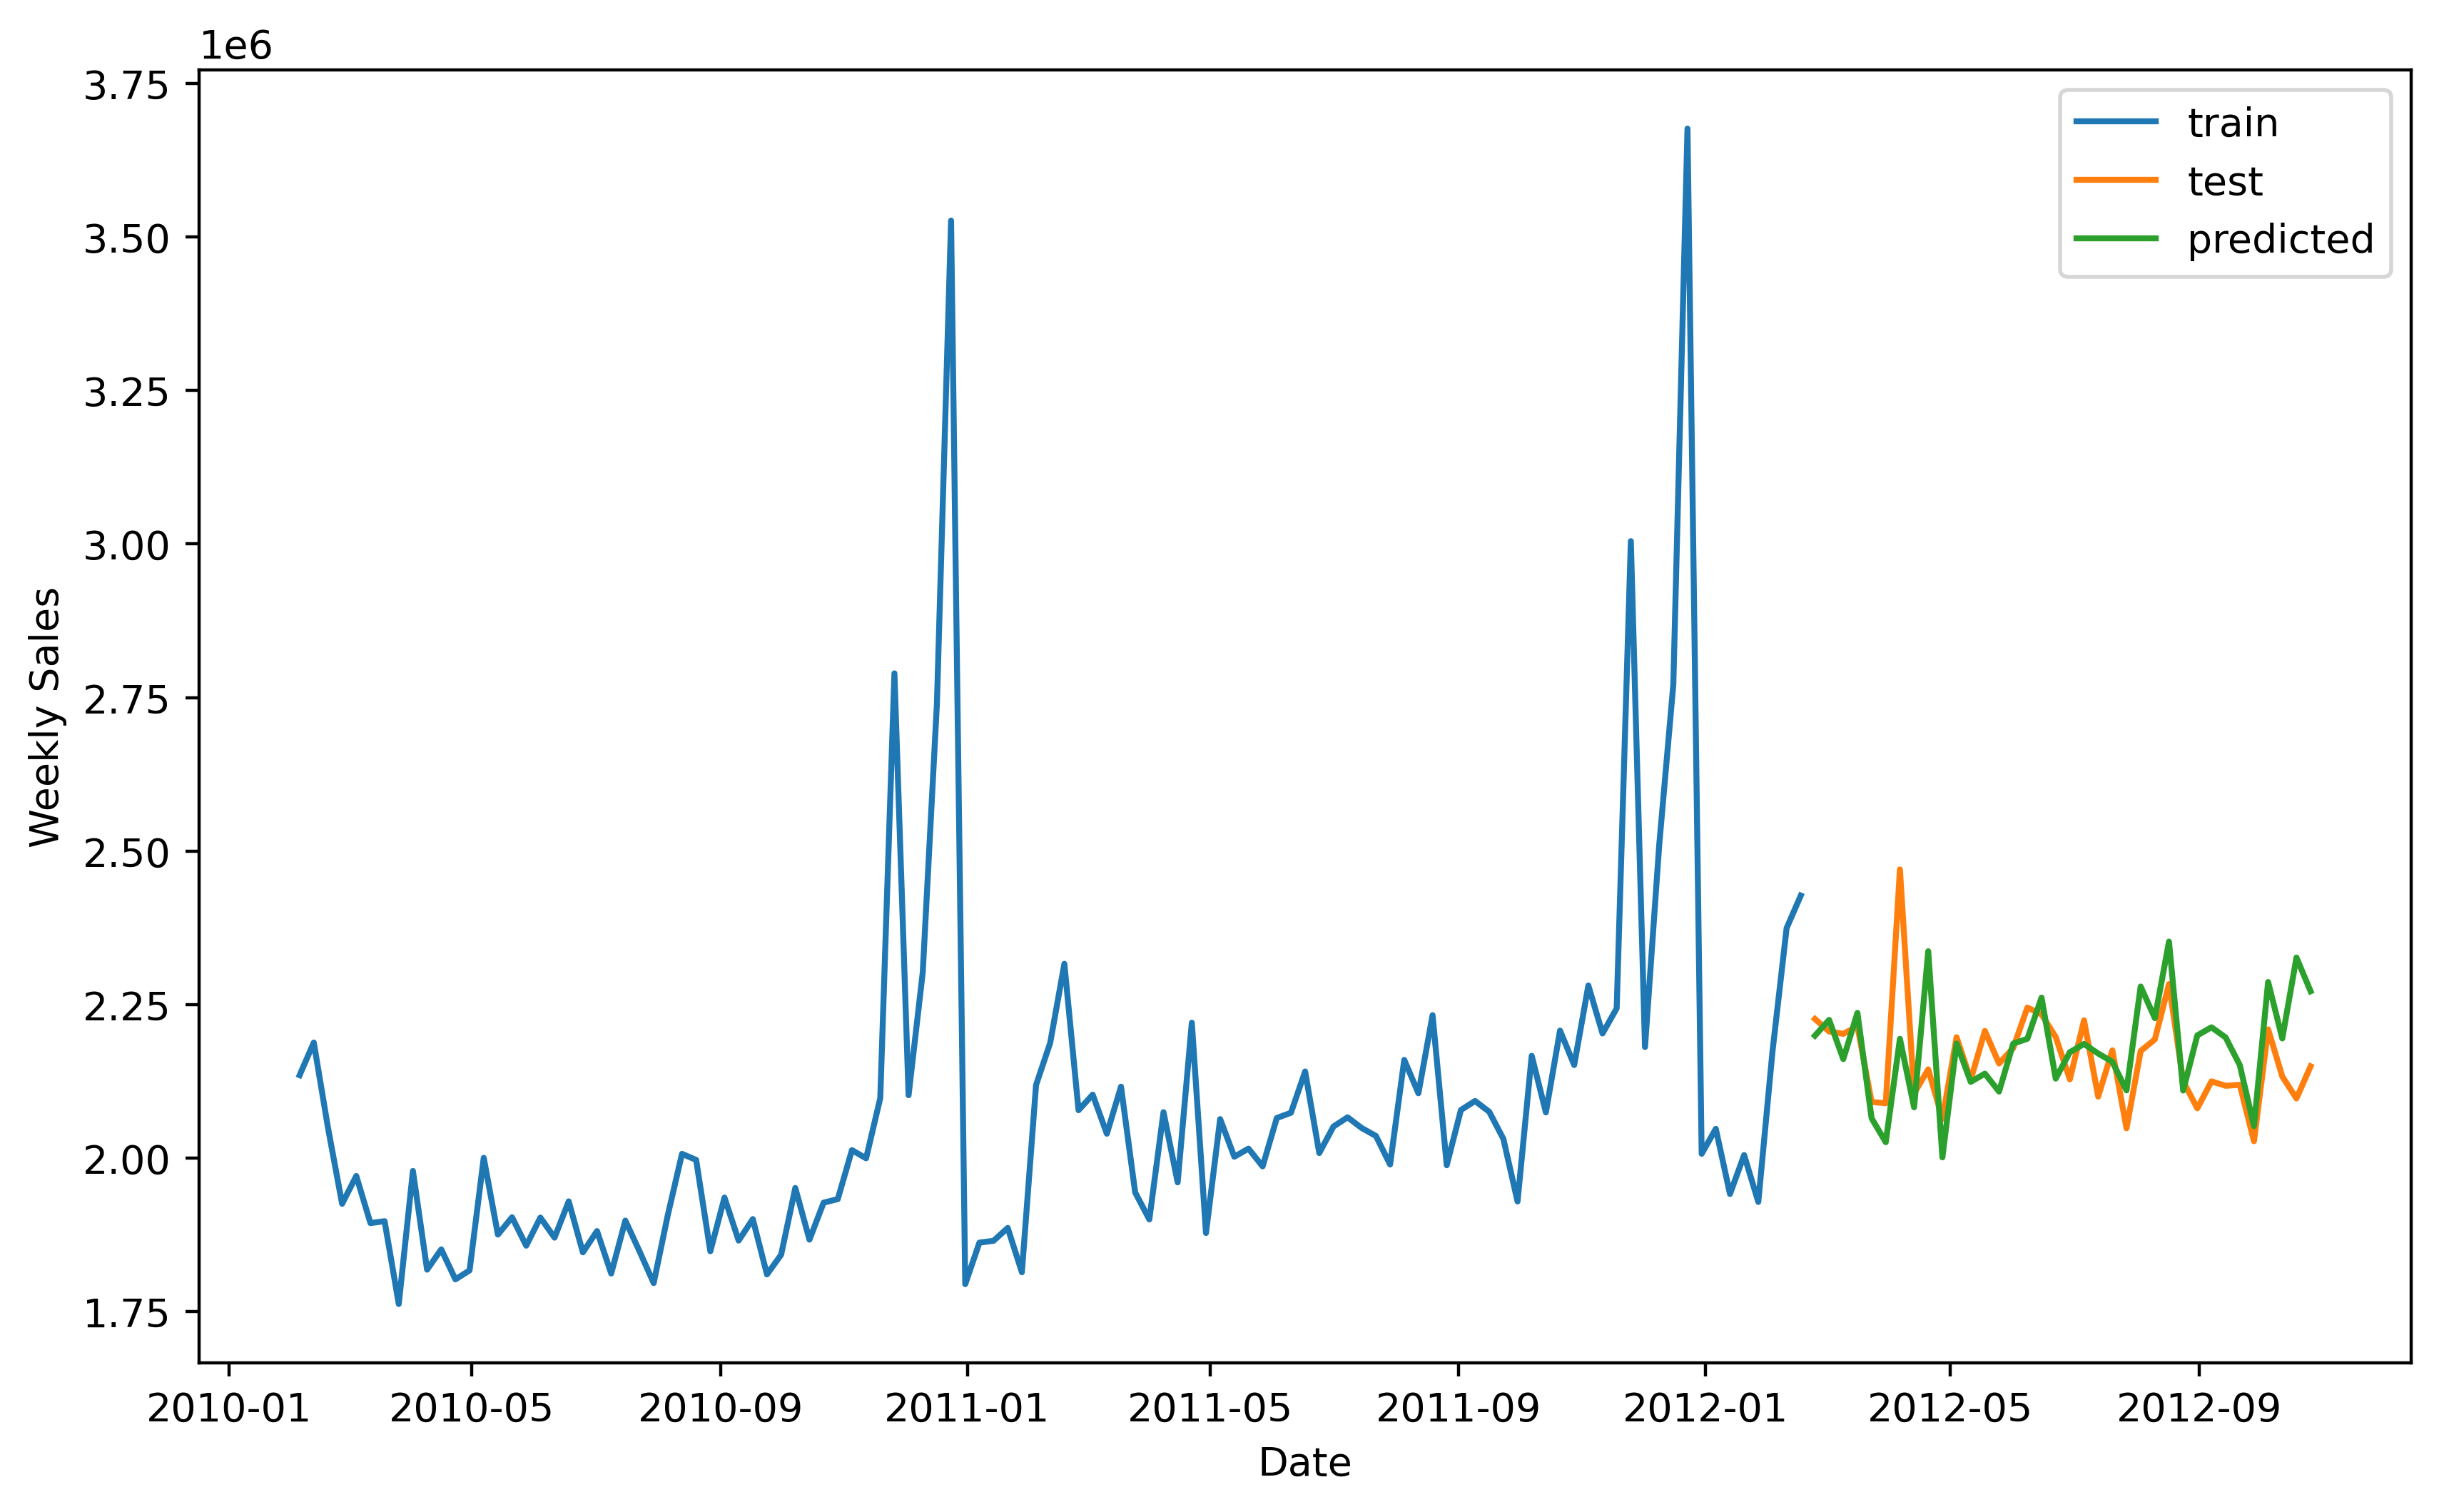

In [144]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = "train")
plt.plot(test, label = "test");
plt.plot(yhat_sarima, label = "predicted")
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.legend();

## ExponentialSmoothing

In [179]:
model_holt_winters = ExponentialSmoothing(train, seasonal_periods = 52, seasonal = 'additive', trend = 'additive').fit()
yhat_exp = model_holt_winters.forecast(len(test))
print("Mean absolute percentage error -", np.round((abs(yhat_exp - test['Weekly_Sales'])/ test['Weekly_Sales'] * 100).mean(), 1), "%")

Mean absolute percentage error - 2.6 %


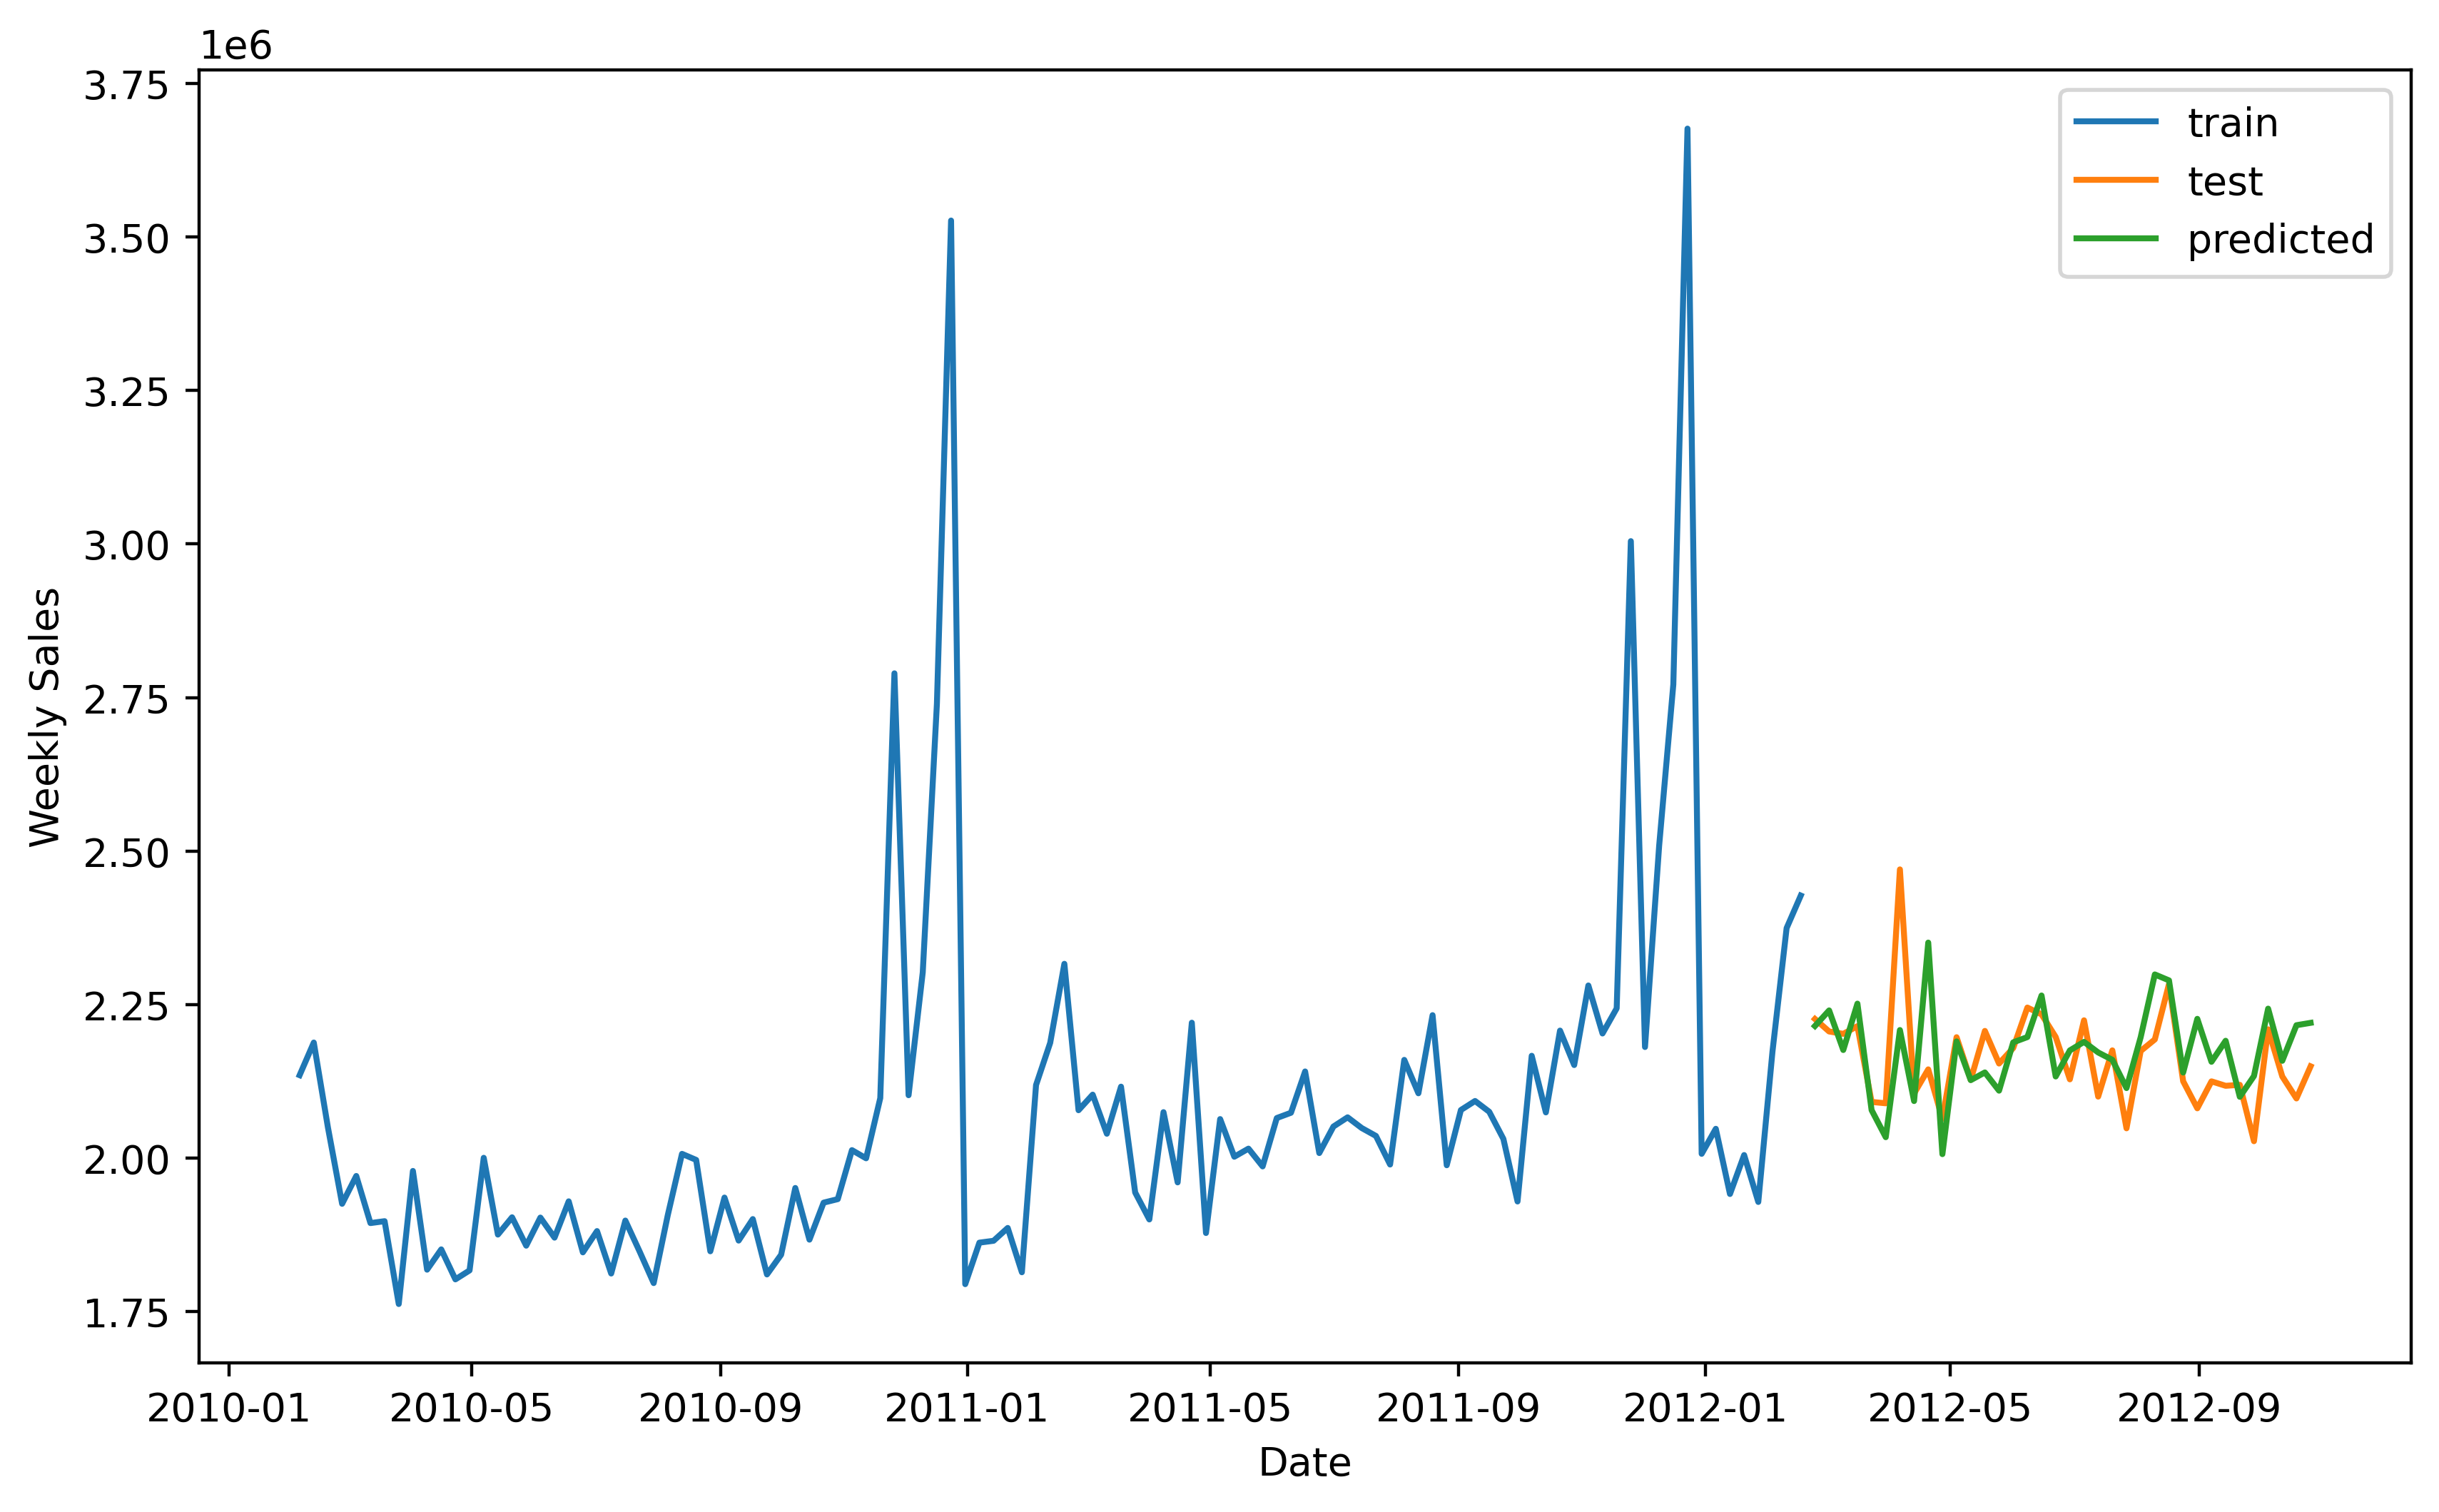

In [146]:
plt.figure(figsize = (10,6), dpi = 400)
plt.plot(train, label = "train")
plt.plot(test, label = "test");
plt.plot(yhat_exp, label = "predicted")
plt.ylabel("Weekly Sales")
plt.xlabel("Date")
plt.legend();

# Running the ExponentialSmoothing and SARIMA models across all the stores

In [217]:
error_exp = []
for i in range(1, 46):
    store = univ_df[univ_df['Store'] == i]
    store.drop('Store', axis = 1, inplace = True)
    train, test = train_test_split(store, test_size = 0.25, shuffle = False)
    model_holt_winters = ExponentialSmoothing(train, seasonal_periods = 52, seasonal = 'additive', trend = 'additive').fit()
    yhat_exp = model_holt_winters.forecast(len(test))
    error_exp.append(np.round((abs(yhat_exp - test['Weekly_Sales'])/ test['Weekly_Sales'] * 100).mean()))

In [218]:
error_sarima = []
for i in range(1, 46):
    store = univ_df[univ_df['Store'] == i]
    store.drop('Store', axis = 1, inplace = True)
    train, test = train_test_split(store, test_size = 0.25, shuffle = False)
    model = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 52)).fit() # lags = 0, differencing = 1, moving average = 1, seasonal value = 52
#     start_test = test.index[0]
#     end_test = test.index[-1]
#     yhat_sarima = model.predict(start = start_test, end = end_test)
    yhat_sarima = results(model, test, store)
    error_sarima.append(np.round((abs(yhat_sarima - test['Weekly_Sales'])/ test['Weekly_Sales'] * 100).mean()))

Mean absolute percentage error - 5.1 %
Mean absolute percentage error - 3.0 %
Mean absolute percentage error - 3.2 %
Mean absolute percentage error - 3.0 %
Mean absolute percentage error - 5.4 %
Mean absolute percentage error - 3.0 %
Mean absolute percentage error - 6.2 %
Mean absolute percentage error - 3.0 %
Mean absolute percentage error - 5.0 %
Mean absolute percentage error - 4.3 %
Mean absolute percentage error - 3.9 %
Mean absolute percentage error - 8.3 %
Mean absolute percentage error - 6.5 %
Mean absolute percentage error - 15.2 %
Mean absolute percentage error - 5.0 %
Mean absolute percentage error - 4.6 %
Mean absolute percentage error - 2.8 %
Mean absolute percentage error - 5.2 %
Mean absolute percentage error - 3.8 %
Mean absolute percentage error - 3.9 %
Mean absolute percentage error - 4.4 %
Mean absolute percentage error - 3.9 %
Mean absolute percentage error - 4.6 %
Mean absolute percentage error - 4.8 %
Mean absolute percentage error - 3.8 %
Mean absolute percentage

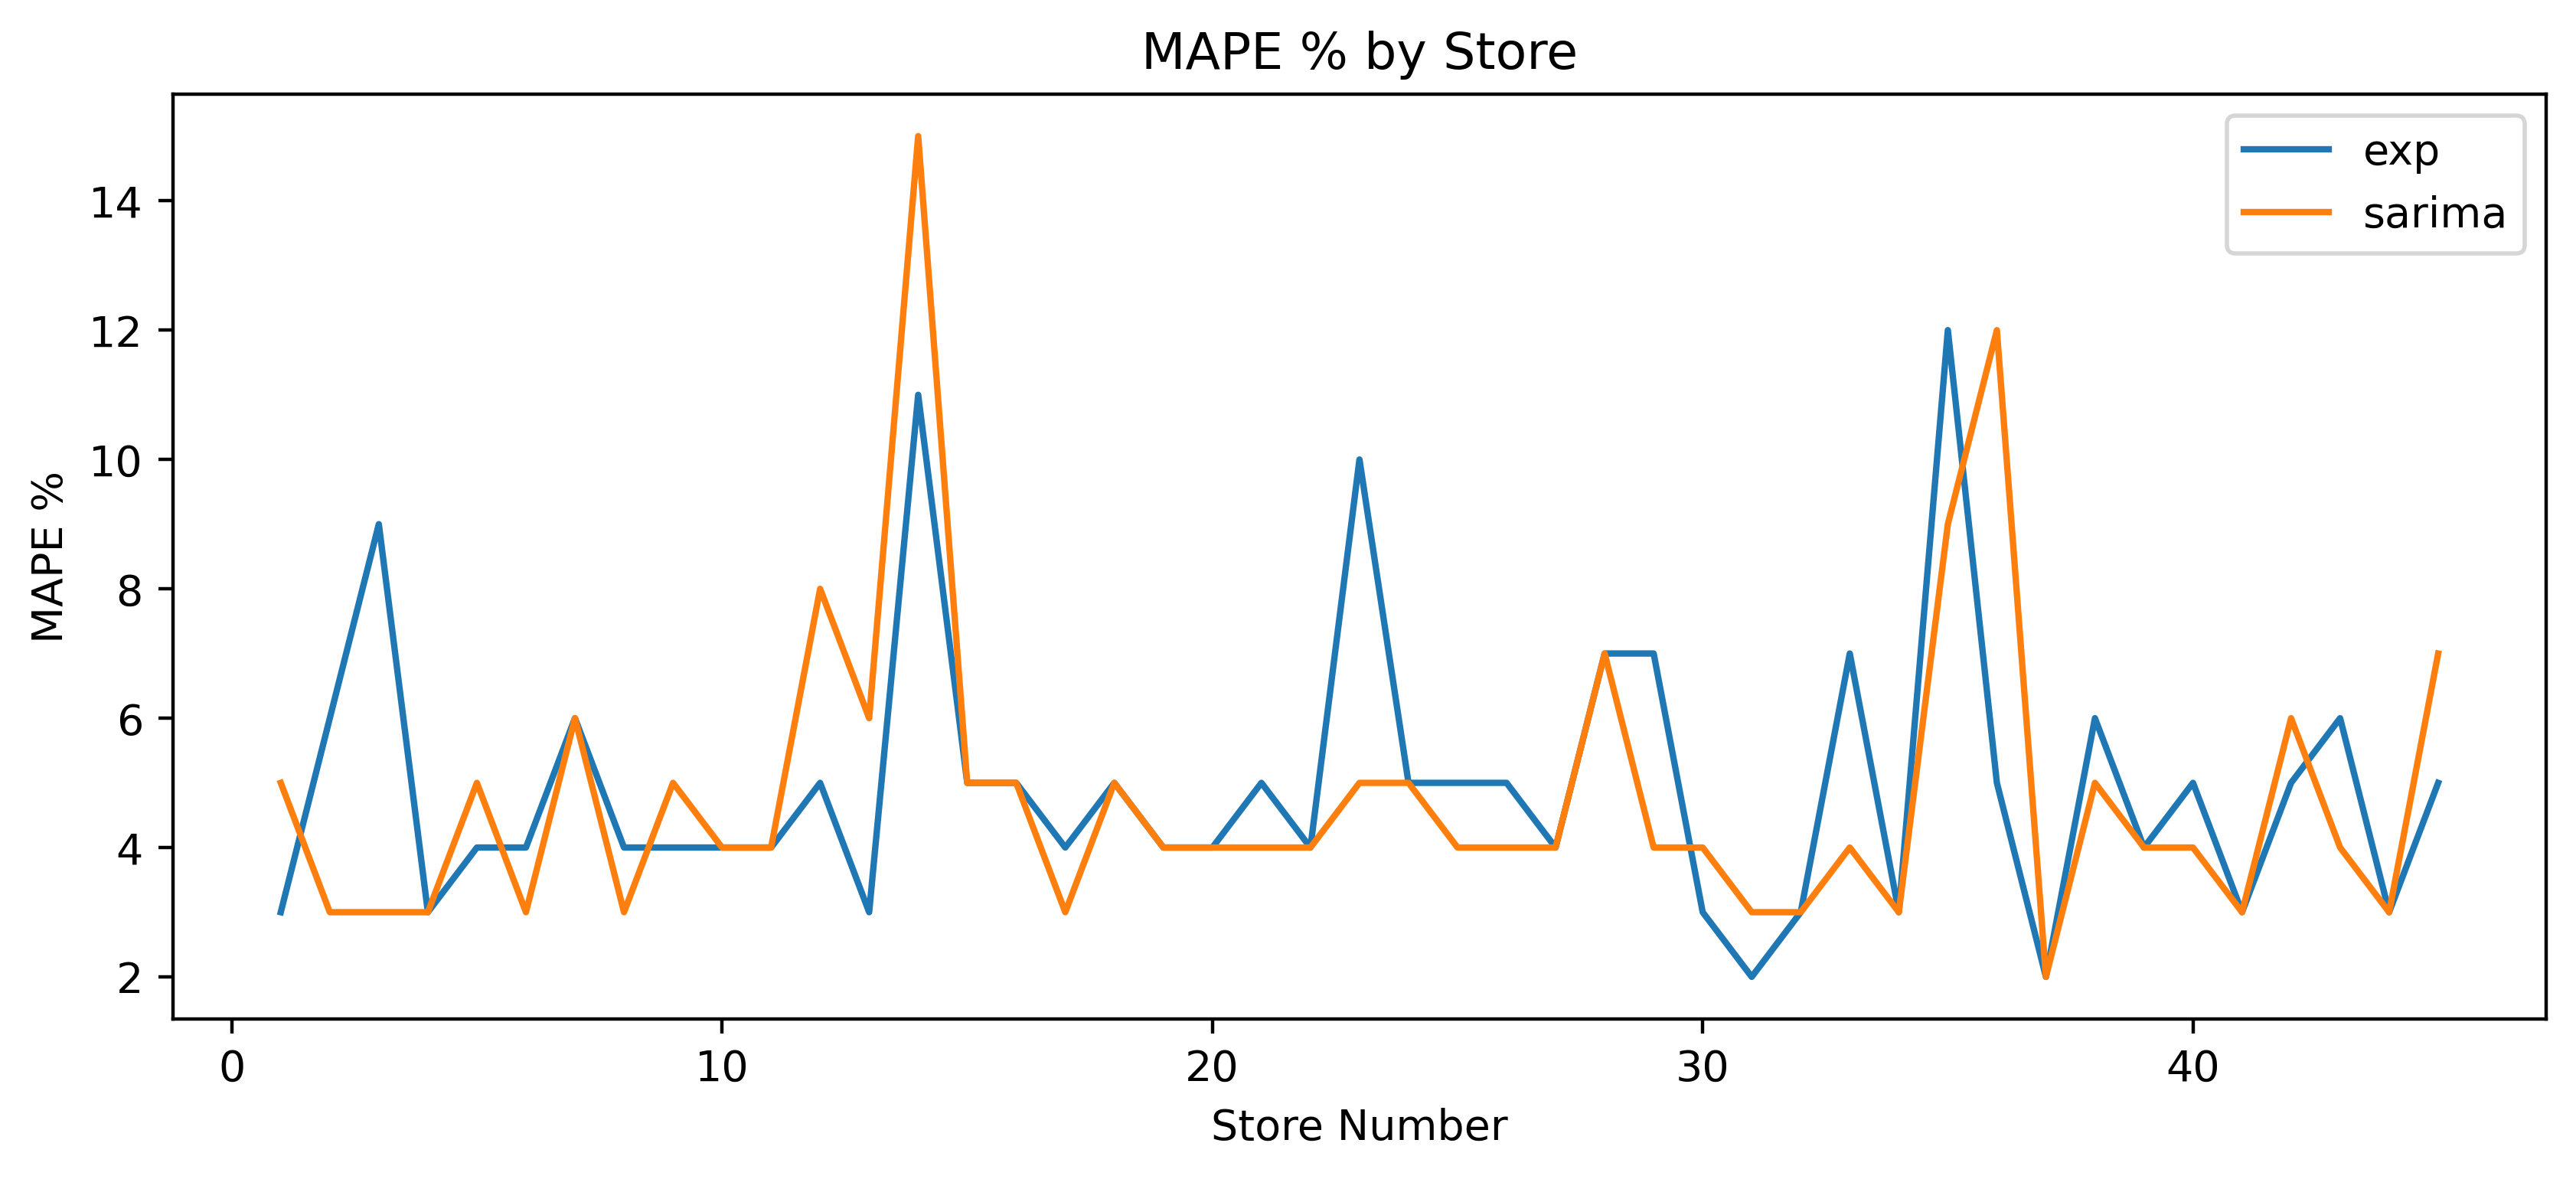

In [228]:
plt.figure(figsize = (10,4), dpi = 400)
plt.plot(range(1,46), error_exp, label = 'exp')
plt.plot(range(1,46), error_sarima, label = 'sarima')
plt.legend()
plt.xlabel('Store Number')
plt.ylabel('MAPE %')
plt.title('MAPE % by Store');

In [226]:
print("Mean MAPE for ExponentialSmoothing -", np.round(statistics.mean(error_exp), 1), "%")
print("Mean MAPE for Sarima -", statistics.mean(error_sarima), "%")
print()
print("Median MAPE for ExponentialSmoothing -", statistics.median(error_exp), "%")
print("Median MAPE for Sarima -", statistics.median(error_sarima), "%")

Mean MAPE for ExponentialSmoothing - 5.0 %
Mean MAPE for Sarima - 4.8 %

Median MAPE for ExponentialSmoothing - 5.0 %
Median MAPE for Sarima - 4.0 %
